In [1]:
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageFont, ImageDraw
from scipy.stats import norm
import numpy as np
from tqdm import tqdm
import random
from string import ascii_letters, digits

In [2]:
# ---------------------------
# 1. Hyperparameters
# ---------------------------
batch_size = 64
image_size = 64
num_epochs = 5
learning_rate_D = 3e-5
learning_rate_G = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [56]:
# ---------------------------
# 2. Custom Dataset Loader (For ./data/train/*.png)
# ---------------------------
class CaptchaDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_path).convert('1')  # Ensure binary format
        if self.transform:
            image = self.transform(image)
        return image

# Define transformation pipeline
transform = transforms.Compose([
    transforms.Resize((80, 800)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1,1]
])

# Create dataset and dataloader
dataset = CaptchaDataset(image_folder="./data/preprocessed_images", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

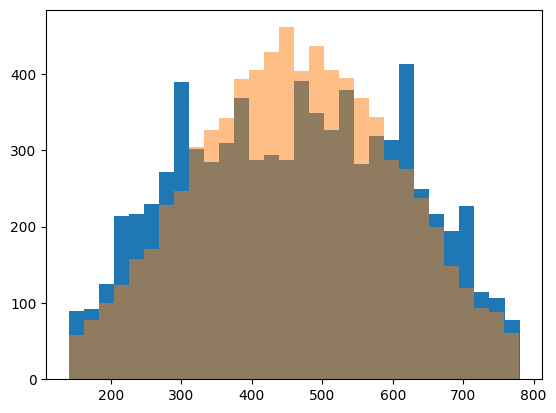

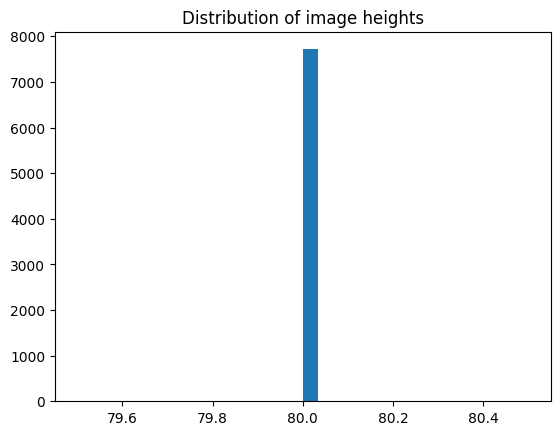

In [57]:
dataset_explore = CaptchaDataset(image_folder="./data/preprocessed_images", transform=None)
# plot image dimensions distribution in the dataset
widths = list(map(lambda image: image.size[0], dataset_explore))
plt.hist(widths, bins=30)

# fit a normal distribution to the data
min_width = min(widths)
max_width = max(widths)
mu, std = norm.fit(widths)

# sample and compare
sampled_widths = norm.rvs(mu, std, 8000)
sampled_widths = sampled_widths[(sampled_widths >= min_width) & (sampled_widths <= max_width)]
plt.hist(sampled_widths, bins=30, alpha=0.5)
plt.show()


heights = list(map(lambda image: image.size[1], dataset_explore))
plt.hist(heights, bins=30)
plt.title("Distribution of image heights")
plt.show()

### Captcha generation pipeline
Use PIL to generate a captcha image of size (w, 80)
where w is sampled using normal distribution params obtained above

For each image, randomly choose these params:
1. width: image width sampled from distribution above
1. font: text font in a captcha, random chosen in a pre-defined subset.
    - TODO: generate captcha that contains more than 1 font
1. font_size: font size of each letter
1. gap: (expected) spearation between each 2 letters
1. center_height: (expected) central height of letters

For each character in the image, randomly choose these params:
1. char: the character itself, in alphanumeric
1. x_displacement: small horizontal displacement
1. y_displacement: small vertical displacement
1. rotation: anticlockwise rotation in degrees

Use these params to draw letters in binary format until right margin

In [58]:
# Known values
MU = mu
STD = std
MIN_WIDTH = min_width
MAX_WIDTH = max_width
print(f"mu: {MU}, std: {STD}, min_width: {MIN_WIDTH}, max_width: {MAX_WIDTH}")

LEFT_MARGIN = 30 # if x position is below this value, regenerate

HEIGHT = 80
FONT_FILENAMES = [f for f in os.listdir("./GAN/fonts") if f.endswith('.ttf')]
FONTSIZE_MIN = 28
FONTSIZE_MAX = 40
GAP_MIN = 5 # should not be too high, need some overlap
GAP_MAX = 30

TRANSLATION_PROBABILITY = 0.5
X_DISPLACEMENT_MIN = -5
X_DISPLACEMENT_MAX = 5
Y_DISPLACEMENT_MIN = -5
Y_DISPLACEMENT_MAX = 5
ROTATION_PROBABILITY = 0.5
ROTATION_MIN = -30
ROTATION_MAX = 30

ALPHANUMERIC = ascii_letters + digits

mu: 459.9397278029812, std: 154.63231617159508, min_width: 140, max_width: 780


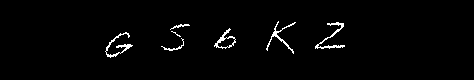

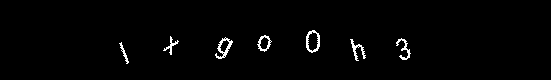

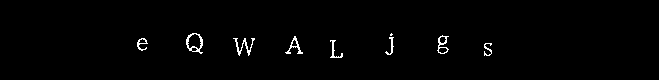

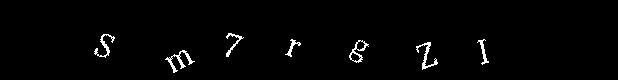

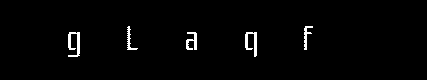

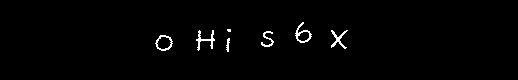

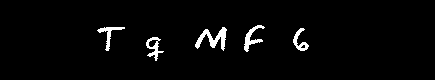

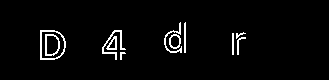

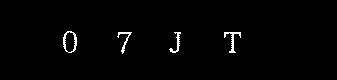

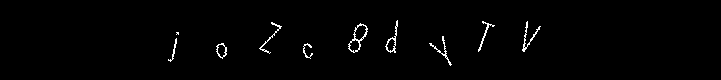

In [59]:
def get_random_width(mu, std, min_width, max_width):
    w = int(norm.rvs(mu, std))
    if w >= min_width and w <= max_width:
        return w
    return get_random_width(mu, std, min_width, max_width)


def generate_random_captcha(return_label = False):
    width = get_random_width(MU, STD, MIN_WIDTH, MAX_WIDTH)
    height = HEIGHT
    font_size = random.randint(FONTSIZE_MIN, FONTSIZE_MAX)
    font = ImageFont.truetype("./GAN/fonts/" + random.choice(FONT_FILENAMES), font_size)
    gap = random.randint(GAP_MIN, GAP_MAX)
    center_height = random.randint(HEIGHT // 20 * 9, HEIGHT // 20 * 11)
    has_translation = random.random() < TRANSLATION_PROBABILITY
    has_rotation = random.random() < ROTATION_PROBABILITY

    # Approximation for the number of characters
    # TODO: check distribution of num characters generated and change this if needed
    num_chars = max(min((width - LEFT_MARGIN * 2) // 70, 9), 4)

    img = Image.new('1', (width, height))
    label = ""

    for i in range(num_chars):
        # Draw a character (pun intended)
        char = random.choice(ALPHANUMERIC)
        label += char

        expected_x_disp_in_characters_from_center = i - num_chars / 2
        expected_x_start = width / 2 + (font_size + gap) * expected_x_disp_in_characters_from_center

        # TODO: check distribution, change random function if needed
        x_displacement = 0
        y_displacement = 0
        rotation = 0
        if has_translation:
          x_displacement = random.randint(X_DISPLACEMENT_MIN, X_DISPLACEMENT_MAX)
          y_displacement = random.randint(Y_DISPLACEMENT_MIN, Y_DISPLACEMENT_MAX)
        if has_rotation:
          rotation = random.randint(ROTATION_MIN, ROTATION_MAX)

        x_start = int(expected_x_start + x_displacement)
        char_height = font.getmetrics()[0] + font.getmetrics()[1] # ascent + descent
        y_start = int(center_height - char_height / 2 + y_displacement)

        # regenerate if out of bounds
        if x_start < LEFT_MARGIN:
            return generate_random_captcha(return_label)
        elif y_start + char_height > height or y_start < 0:
            return generate_random_captcha(return_label)

        text_img = Image.new('L', (char_height, char_height))
        text_draw = ImageDraw.Draw(text_img)
        text_draw.text((0, 0), char, font=font, fill=255, spacing=0)
        text_img = text_img.rotate(rotation, expand=True)
        img.paste(text_img, (x_start, y_start), text_img)

    # print(font.getname())
    if not return_label:
        return img
    else:
        return img, label.lower()

for i in range(10):
    img = generate_random_captcha()
    display(img)

In [55]:
def display_image(img_tensor):
    img_array = ((img_tensor.numpy() * 0.5 + 0.5) * 255).astype(np.uint8)
    img_array[img_array < 128] = 0
    img_array[img_array >= 128] = 255
    display(Image.fromarray(img_array[0], 'L'))

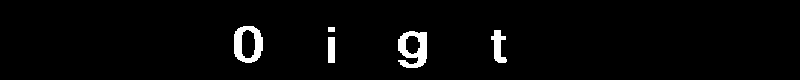

In [8]:
display_image(dataset[11])

In [5]:
class Generator(nn.Module):
    def __init__(self, img_channels=1, feature_g=64, num_res_blocks = 4):
        super(Generator, self).__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, feature_g, 3, 1, 1),
            nn.ReLU(inplace=True)
        )

        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(feature_g, feature_g, 3, 1, 1),
                # nn.BatchNorm2d(feature_g),
                nn.ReLU(inplace=True),
                nn.Conv2d(feature_g, feature_g, 3, 1, 1),
                # nn.BatchNorm2d(feature_g)
            )
         for _ in range(num_res_blocks)])

        self.final = nn.Sequential(
            nn.Conv2d(feature_g, img_channels, 1, 1, 0),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        for b in self.residual_blocks:
            x = x + b(x)
        x = self.final(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, img_channels=1, feature_d=128):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 80 * 800
            nn.Conv2d(img_channels, feature_d, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(feature_d),
            # 40 * 400
            nn.ReLU(),


            nn.Conv2d(feature_d, feature_d // 2, 4, 2, 1, bias=False),
            # 20 * 200
            # nn.BatchNorm2d(feature_d * 2),
            nn.MaxPool2d((2, 2), (2, 2)),
            # 10 * 80
            nn.ReLU(),

            nn.Conv2d(feature_d // 2, feature_d // 4, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(feature_d * 4),
            # 5 * 40
            nn.ReLU(),

            nn.Conv2d(feature_d // 4, 1, 5, 1, 0),
            # 1 * 36

            nn.AdaptiveAvgPool2d(1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()
def self_regularisation_loss(fake, real, delta=3e-6):
    return delta * torch.sum(torch.abs(fake - real))

optimizerD = torch.optim.Adam(netD.parameters(), lr=learning_rate_D, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=learning_rate_G, betas=(0.5, 0.999))

clip_grad_norm_(netG.parameters(), 1)

In [10]:
import gc

gc.collect()

torch.cuda.empty_cache()

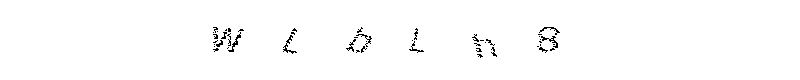

Epoch [0/5] Batch 0/121 Loss D: 1.3963, Loss G: 15.7060
Epoch [0/5] Batch 1/121 Loss D: 1.3926, Loss G: 13.9589
Epoch [0/5] Batch 2/121 Loss D: 1.3879, Loss G: 12.0792
Epoch [0/5] Batch 3/121 Loss D: 1.3840, Loss G: 10.1183
Epoch [0/5] Batch 4/121 Loss D: 1.3826, Loss G: 8.1600


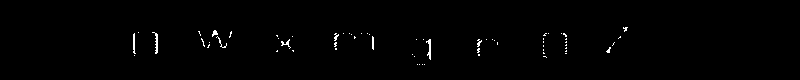

Epoch [0/5] Batch 5/121 Loss D: 1.3818, Loss G: 6.3305
Epoch [0/5] Batch 6/121 Loss D: 1.3821, Loss G: 4.7665
Epoch [0/5] Batch 7/121 Loss D: 1.3822, Loss G: 3.5110
Epoch [0/5] Batch 8/121 Loss D: 1.3827, Loss G: 2.5848
Epoch [0/5] Batch 9/121 Loss D: 1.3823, Loss G: 1.9545


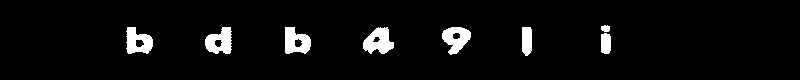

Epoch [0/5] Batch 10/121 Loss D: 1.3822, Loss G: 1.6331
Epoch [0/5] Batch 11/121 Loss D: 1.3820, Loss G: 1.4206
Epoch [0/5] Batch 12/121 Loss D: 1.3802, Loss G: 1.2719
Epoch [0/5] Batch 13/121 Loss D: 1.3819, Loss G: 1.1613
Epoch [0/5] Batch 14/121 Loss D: 1.3802, Loss G: 1.0757


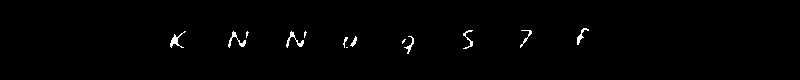

Epoch [0/5] Batch 15/121 Loss D: 1.3806, Loss G: 1.0429
Epoch [0/5] Batch 16/121 Loss D: 1.3804, Loss G: 0.9724
Epoch [0/5] Batch 17/121 Loss D: 1.3796, Loss G: 0.9406
Epoch [0/5] Batch 18/121 Loss D: 1.3795, Loss G: 0.9215
Epoch [0/5] Batch 19/121 Loss D: 1.3789, Loss G: 0.9032


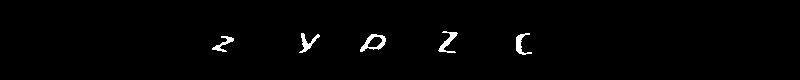

Epoch [0/5] Batch 20/121 Loss D: 1.3795, Loss G: 0.8774
Epoch [0/5] Batch 21/121 Loss D: 1.3789, Loss G: 0.8550
Epoch [0/5] Batch 22/121 Loss D: 1.3789, Loss G: 0.8570
Epoch [0/5] Batch 23/121 Loss D: 1.3770, Loss G: 0.8512
Epoch [0/5] Batch 24/121 Loss D: 1.3769, Loss G: 0.8392


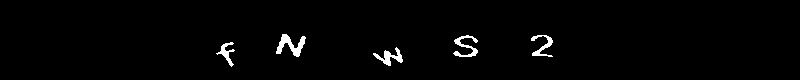

Epoch [0/5] Batch 25/121 Loss D: 1.3785, Loss G: 0.8321
Epoch [0/5] Batch 26/121 Loss D: 1.3730, Loss G: 0.8242
Epoch [0/5] Batch 27/121 Loss D: 1.3750, Loss G: 0.8251
Epoch [0/5] Batch 28/121 Loss D: 1.3747, Loss G: 0.8176
Epoch [0/5] Batch 29/121 Loss D: 1.3748, Loss G: 0.8099


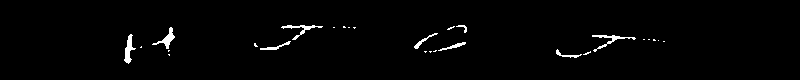

Epoch [0/5] Batch 30/121 Loss D: 1.3689, Loss G: 0.8051
Epoch [0/5] Batch 31/121 Loss D: 1.3706, Loss G: 0.8034
Epoch [0/5] Batch 32/121 Loss D: 1.3712, Loss G: 0.7958
Epoch [0/5] Batch 33/121 Loss D: 1.3685, Loss G: 0.7978
Epoch [0/5] Batch 34/121 Loss D: 1.3680, Loss G: 0.7997


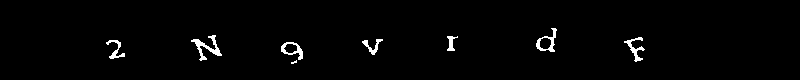

Epoch [0/5] Batch 35/121 Loss D: 1.3658, Loss G: 0.8009
Epoch [0/5] Batch 36/121 Loss D: 1.3683, Loss G: 0.7905
Epoch [0/5] Batch 37/121 Loss D: 1.3643, Loss G: 0.7980
Epoch [0/5] Batch 38/121 Loss D: 1.3652, Loss G: 0.7962
Epoch [0/5] Batch 39/121 Loss D: 1.3670, Loss G: 0.7893


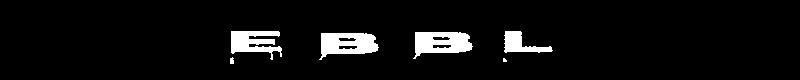

Epoch [0/5] Batch 40/121 Loss D: 1.3591, Loss G: 0.7887
Epoch [0/5] Batch 41/121 Loss D: 1.3546, Loss G: 0.7833
Epoch [0/5] Batch 42/121 Loss D: 1.3585, Loss G: 0.7860
Epoch [0/5] Batch 43/121 Loss D: 1.3637, Loss G: 0.7821
Epoch [0/5] Batch 44/121 Loss D: 1.3583, Loss G: 0.7893


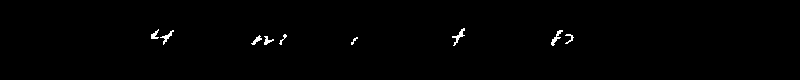

Epoch [0/5] Batch 45/121 Loss D: 1.3559, Loss G: 0.7797
Epoch [0/5] Batch 46/121 Loss D: 1.3521, Loss G: 0.7806
Epoch [0/5] Batch 47/121 Loss D: 1.3542, Loss G: 0.7859
Epoch [0/5] Batch 48/121 Loss D: 1.3395, Loss G: 0.7858
Epoch [0/5] Batch 49/121 Loss D: 1.3473, Loss G: 0.7761


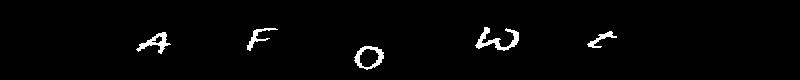

Epoch [0/5] Batch 50/121 Loss D: 1.3507, Loss G: 0.7798
Epoch [0/5] Batch 51/121 Loss D: 1.3419, Loss G: 0.7790
Epoch [0/5] Batch 52/121 Loss D: 1.3456, Loss G: 0.7741
Epoch [0/5] Batch 53/121 Loss D: 1.3381, Loss G: 0.7771
Epoch [0/5] Batch 54/121 Loss D: 1.3390, Loss G: 0.7761


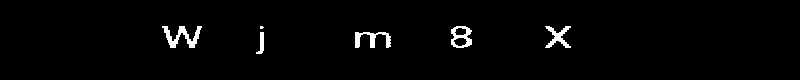

Epoch [0/5] Batch 55/121 Loss D: 1.3186, Loss G: 0.7824
Epoch [0/5] Batch 56/121 Loss D: 1.3257, Loss G: 0.7767
Epoch [0/5] Batch 57/121 Loss D: 1.3266, Loss G: 0.7788
Epoch [0/5] Batch 58/121 Loss D: 1.3243, Loss G: 0.7729
Epoch [0/5] Batch 59/121 Loss D: 1.3255, Loss G: 0.7672


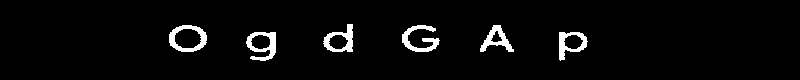

Epoch [0/5] Batch 60/121 Loss D: 1.3059, Loss G: 0.7848
Epoch [0/5] Batch 61/121 Loss D: 1.3230, Loss G: 0.7706
Epoch [0/5] Batch 62/121 Loss D: 1.2854, Loss G: 0.7801
Epoch [0/5] Batch 63/121 Loss D: 1.2944, Loss G: 0.7864
Epoch [0/5] Batch 64/121 Loss D: 1.3205, Loss G: 0.7742


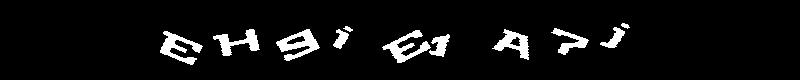

Epoch [0/5] Batch 65/121 Loss D: 1.2930, Loss G: 0.7786
Epoch [0/5] Batch 66/121 Loss D: 1.3064, Loss G: 0.7756
Epoch [0/5] Batch 67/121 Loss D: 1.2880, Loss G: 0.7842
Epoch [0/5] Batch 68/121 Loss D: 1.3047, Loss G: 0.7653
Epoch [0/5] Batch 69/121 Loss D: 1.2871, Loss G: 0.7782


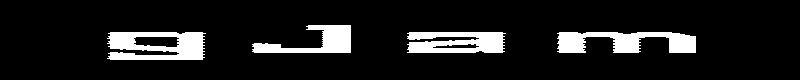

Epoch [0/5] Batch 70/121 Loss D: 1.2988, Loss G: 0.7726
Epoch [0/5] Batch 71/121 Loss D: 1.2932, Loss G: 0.7897
Epoch [0/5] Batch 72/121 Loss D: 1.2715, Loss G: 0.7745
Epoch [0/5] Batch 73/121 Loss D: 1.2889, Loss G: 0.7884
Epoch [0/5] Batch 74/121 Loss D: 1.2442, Loss G: 0.7764


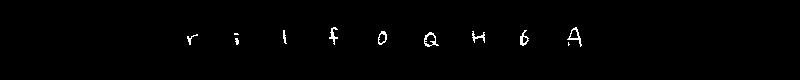

Epoch [0/5] Batch 75/121 Loss D: 1.2583, Loss G: 0.7890
Epoch [0/5] Batch 76/121 Loss D: 1.2802, Loss G: 0.7839
Epoch [0/5] Batch 77/121 Loss D: 1.3119, Loss G: 0.7751
Epoch [0/5] Batch 78/121 Loss D: 1.2710, Loss G: 0.7767
Epoch [0/5] Batch 79/121 Loss D: 1.2057, Loss G: 0.8157


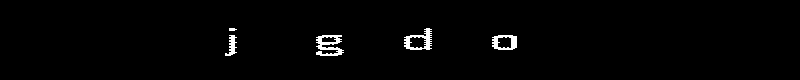

Epoch [0/5] Batch 80/121 Loss D: 1.2606, Loss G: 0.7997
Epoch [0/5] Batch 81/121 Loss D: 1.2418, Loss G: 0.7859
Epoch [0/5] Batch 82/121 Loss D: 1.2466, Loss G: 0.7954
Epoch [0/5] Batch 83/121 Loss D: 1.2380, Loss G: 0.8029
Epoch [0/5] Batch 84/121 Loss D: 1.2085, Loss G: 0.8244


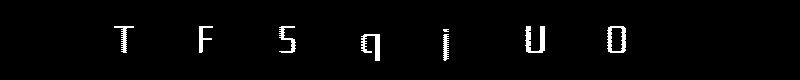

Epoch [0/5] Batch 85/121 Loss D: 1.2535, Loss G: 0.8123
Epoch [0/5] Batch 86/121 Loss D: 1.1693, Loss G: 0.8329
Epoch [0/5] Batch 87/121 Loss D: 1.1873, Loss G: 0.8379
Epoch [0/5] Batch 88/121 Loss D: 1.2623, Loss G: 0.8116
Epoch [0/5] Batch 89/121 Loss D: 1.1692, Loss G: 0.8402


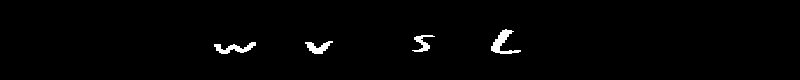

Epoch [0/5] Batch 90/121 Loss D: 1.2127, Loss G: 0.8190
Epoch [0/5] Batch 91/121 Loss D: 1.1720, Loss G: 0.8305
Epoch [0/5] Batch 92/121 Loss D: 1.1864, Loss G: 0.8494
Epoch [0/5] Batch 93/121 Loss D: 1.1010, Loss G: 0.8675
Epoch [0/5] Batch 94/121 Loss D: 1.2056, Loss G: 0.8656


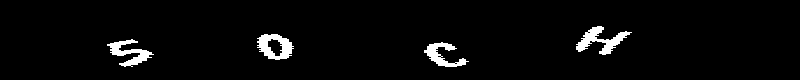

Epoch [0/5] Batch 95/121 Loss D: 1.1529, Loss G: 0.8853
Epoch [0/5] Batch 96/121 Loss D: 1.1136, Loss G: 0.8871
Epoch [0/5] Batch 97/121 Loss D: 1.1488, Loss G: 0.8830
Epoch [0/5] Batch 98/121 Loss D: 1.0565, Loss G: 0.9065
Epoch [0/5] Batch 99/121 Loss D: 1.1401, Loss G: 0.8943


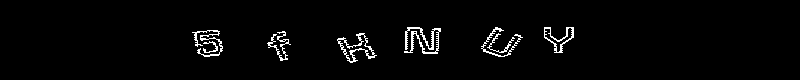

Epoch [0/5] Batch 100/121 Loss D: 1.2119, Loss G: 0.8790
Epoch [0/5] Batch 101/121 Loss D: 1.0848, Loss G: 0.9100
Epoch [0/5] Batch 102/121 Loss D: 1.0728, Loss G: 0.9437
Epoch [0/5] Batch 103/121 Loss D: 1.0716, Loss G: 0.9294
Epoch [0/5] Batch 104/121 Loss D: 1.1504, Loss G: 0.9036


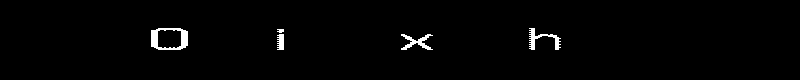

Epoch [0/5] Batch 105/121 Loss D: 1.0100, Loss G: 0.9852
Epoch [0/5] Batch 106/121 Loss D: 1.1655, Loss G: 0.9260
Epoch [0/5] Batch 107/121 Loss D: 1.1852, Loss G: 0.8924
Epoch [0/5] Batch 108/121 Loss D: 1.0748, Loss G: 0.9475
Epoch [0/5] Batch 109/121 Loss D: 1.0843, Loss G: 0.9528


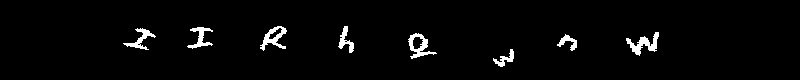

Epoch [0/5] Batch 110/121 Loss D: 1.1258, Loss G: 0.9323
Epoch [0/5] Batch 111/121 Loss D: 1.0837, Loss G: 0.9332
Epoch [0/5] Batch 112/121 Loss D: 1.0751, Loss G: 0.9796
Epoch [0/5] Batch 113/121 Loss D: 1.0390, Loss G: 0.9893
Epoch [0/5] Batch 114/121 Loss D: 1.1774, Loss G: 0.8855


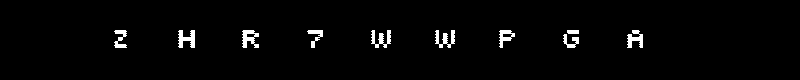

Epoch [0/5] Batch 115/121 Loss D: 1.1274, Loss G: 0.8986
Epoch [0/5] Batch 116/121 Loss D: 1.1441, Loss G: 0.9483
Epoch [0/5] Batch 117/121 Loss D: 1.1407, Loss G: 0.9469
Epoch [0/5] Batch 118/121 Loss D: 1.0196, Loss G: 0.9661
Epoch [0/5] Batch 119/121 Loss D: 1.0464, Loss G: 1.0086


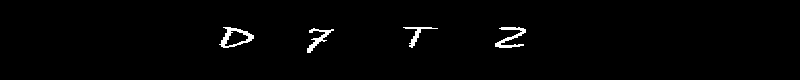

Epoch [0/5] Batch 120/121 Loss D: 1.1619, Loss G: 0.9769


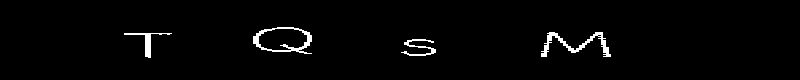

Epoch [1/5] Batch 0/121 Loss D: 1.0810, Loss G: 0.9724
Epoch [1/5] Batch 1/121 Loss D: 1.1489, Loss G: 0.9394
Epoch [1/5] Batch 2/121 Loss D: 1.0745, Loss G: 0.9633
Epoch [1/5] Batch 3/121 Loss D: 1.0801, Loss G: 1.0230
Epoch [1/5] Batch 4/121 Loss D: 1.1039, Loss G: 0.9706


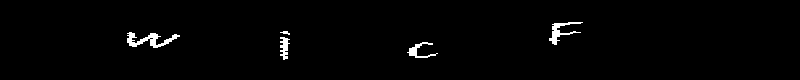

Epoch [1/5] Batch 5/121 Loss D: 1.0011, Loss G: 1.0773
Epoch [1/5] Batch 6/121 Loss D: 1.0452, Loss G: 1.0491
Epoch [1/5] Batch 7/121 Loss D: 1.0439, Loss G: 1.0273
Epoch [1/5] Batch 8/121 Loss D: 1.0986, Loss G: 1.0172
Epoch [1/5] Batch 9/121 Loss D: 1.0910, Loss G: 0.9670


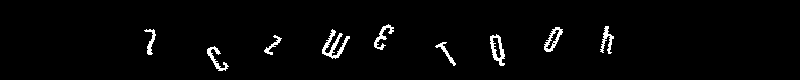

Epoch [1/5] Batch 10/121 Loss D: 0.9607, Loss G: 1.0344
Epoch [1/5] Batch 11/121 Loss D: 0.9727, Loss G: 1.0413
Epoch [1/5] Batch 12/121 Loss D: 1.1116, Loss G: 1.0608
Epoch [1/5] Batch 13/121 Loss D: 1.0358, Loss G: 1.0695
Epoch [1/5] Batch 14/121 Loss D: 1.0911, Loss G: 1.0275


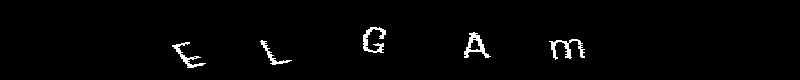

Epoch [1/5] Batch 15/121 Loss D: 0.9399, Loss G: 1.1148
Epoch [1/5] Batch 16/121 Loss D: 1.1288, Loss G: 1.0879
Epoch [1/5] Batch 17/121 Loss D: 1.0141, Loss G: 1.0723
Epoch [1/5] Batch 18/121 Loss D: 1.0485, Loss G: 1.0573
Epoch [1/5] Batch 19/121 Loss D: 1.0563, Loss G: 1.0587


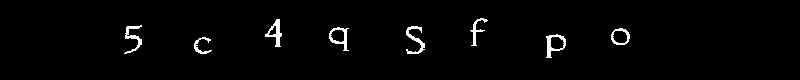

Epoch [1/5] Batch 20/121 Loss D: 1.0774, Loss G: 1.0327
Epoch [1/5] Batch 21/121 Loss D: 1.1153, Loss G: 0.9951
Epoch [1/5] Batch 22/121 Loss D: 0.9782, Loss G: 1.0684
Epoch [1/5] Batch 23/121 Loss D: 1.1123, Loss G: 1.0435
Epoch [1/5] Batch 24/121 Loss D: 1.1159, Loss G: 1.0301


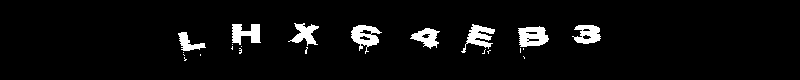

Epoch [1/5] Batch 25/121 Loss D: 1.0726, Loss G: 1.0427
Epoch [1/5] Batch 26/121 Loss D: 1.0276, Loss G: 1.0092
Epoch [1/5] Batch 27/121 Loss D: 0.9171, Loss G: 1.1049
Epoch [1/5] Batch 28/121 Loss D: 1.0193, Loss G: 1.0998
Epoch [1/5] Batch 29/121 Loss D: 1.0660, Loss G: 1.0834


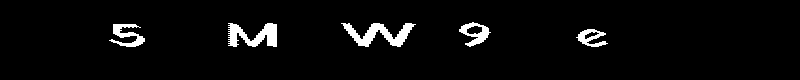

Epoch [1/5] Batch 30/121 Loss D: 1.0935, Loss G: 1.0563
Epoch [1/5] Batch 31/121 Loss D: 1.0891, Loss G: 1.0559
Epoch [1/5] Batch 32/121 Loss D: 0.9977, Loss G: 1.1095
Epoch [1/5] Batch 33/121 Loss D: 1.1332, Loss G: 1.0955
Epoch [1/5] Batch 34/121 Loss D: 1.1081, Loss G: 1.0816


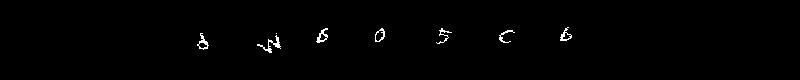

Epoch [1/5] Batch 35/121 Loss D: 0.9150, Loss G: 1.1779
Epoch [1/5] Batch 36/121 Loss D: 1.0774, Loss G: 1.1431
Epoch [1/5] Batch 37/121 Loss D: 1.1506, Loss G: 1.0772
Epoch [1/5] Batch 38/121 Loss D: 0.9796, Loss G: 1.1365
Epoch [1/5] Batch 39/121 Loss D: 1.1569, Loss G: 1.0649


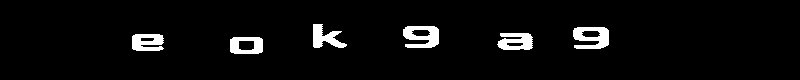

Epoch [1/5] Batch 40/121 Loss D: 1.2709, Loss G: 1.1791
Epoch [1/5] Batch 41/121 Loss D: 1.2323, Loss G: 1.1160
Epoch [1/5] Batch 42/121 Loss D: 1.1605, Loss G: 1.1888
Epoch [1/5] Batch 43/121 Loss D: 1.3710, Loss G: 1.2721
Epoch [1/5] Batch 44/121 Loss D: 1.8051, Loss G: 1.7510


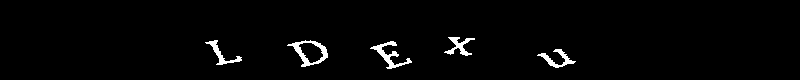

Epoch [1/5] Batch 45/121 Loss D: 1.2240, Loss G: 1.4325
Epoch [1/5] Batch 46/121 Loss D: 1.0284, Loss G: 1.3979
Epoch [1/5] Batch 47/121 Loss D: 1.1365, Loss G: 1.1178
Epoch [1/5] Batch 48/121 Loss D: 0.9712, Loss G: 1.0947
Epoch [1/5] Batch 49/121 Loss D: 1.2818, Loss G: 0.9765


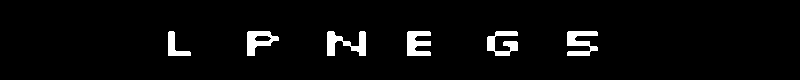

Epoch [1/5] Batch 50/121 Loss D: 1.0789, Loss G: 1.0500
Epoch [1/5] Batch 51/121 Loss D: 1.0175, Loss G: 1.1201
Epoch [1/5] Batch 52/121 Loss D: 1.1884, Loss G: 1.1069
Epoch [1/5] Batch 53/121 Loss D: 1.0833, Loss G: 1.1633
Epoch [1/5] Batch 54/121 Loss D: 1.0264, Loss G: 1.1497


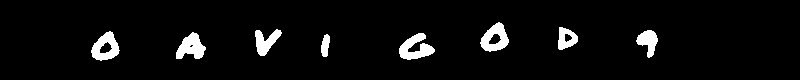

Epoch [1/5] Batch 55/121 Loss D: 1.0878, Loss G: 1.1494
Epoch [1/5] Batch 56/121 Loss D: 1.1761, Loss G: 1.1502
Epoch [1/5] Batch 57/121 Loss D: 1.3175, Loss G: 1.0972
Epoch [1/5] Batch 58/121 Loss D: 1.1425, Loss G: 1.1714
Epoch [1/5] Batch 59/121 Loss D: 1.1539, Loss G: 1.1450


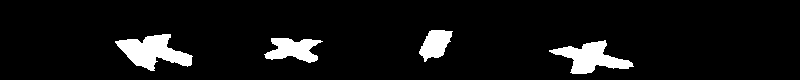

Epoch [1/5] Batch 60/121 Loss D: 1.1604, Loss G: 1.1192
Epoch [1/5] Batch 61/121 Loss D: 1.2035, Loss G: 1.1262
Epoch [1/5] Batch 62/121 Loss D: 1.2447, Loss G: 1.1799
Epoch [1/5] Batch 63/121 Loss D: 1.3662, Loss G: 1.1946
Epoch [1/5] Batch 64/121 Loss D: 1.1322, Loss G: 1.2195


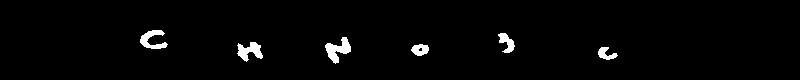

Epoch [1/5] Batch 65/121 Loss D: 1.2301, Loss G: 1.1666
Epoch [1/5] Batch 66/121 Loss D: 1.2653, Loss G: 1.2466
Epoch [1/5] Batch 67/121 Loss D: 1.2056, Loss G: 1.1621
Epoch [1/5] Batch 68/121 Loss D: 1.2515, Loss G: 1.1933
Epoch [1/5] Batch 69/121 Loss D: 1.0855, Loss G: 1.1626


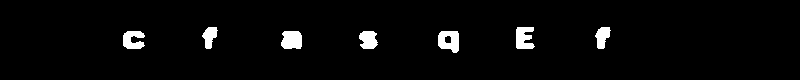

Epoch [1/5] Batch 70/121 Loss D: 1.2488, Loss G: 1.1708
Epoch [1/5] Batch 71/121 Loss D: 1.2983, Loss G: 1.1445
Epoch [1/5] Batch 72/121 Loss D: 1.3299, Loss G: 1.1467
Epoch [1/5] Batch 73/121 Loss D: 1.2411, Loss G: 1.2186
Epoch [1/5] Batch 74/121 Loss D: 1.3323, Loss G: 1.1615


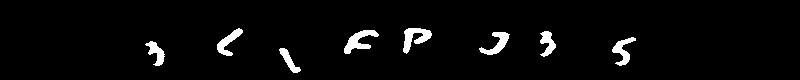

Epoch [1/5] Batch 75/121 Loss D: 1.3067, Loss G: 1.1951
Epoch [1/5] Batch 76/121 Loss D: 1.1447, Loss G: 1.1969
Epoch [1/5] Batch 77/121 Loss D: 1.2537, Loss G: 1.1958
Epoch [1/5] Batch 78/121 Loss D: 1.3020, Loss G: 1.1483
Epoch [1/5] Batch 79/121 Loss D: 1.1580, Loss G: 1.1726


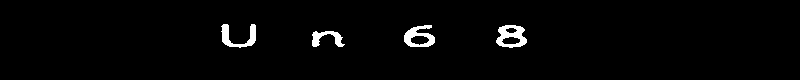

Epoch [1/5] Batch 80/121 Loss D: 1.1697, Loss G: 1.1660
Epoch [1/5] Batch 81/121 Loss D: 1.2018, Loss G: 1.1634
Epoch [1/5] Batch 82/121 Loss D: 1.2348, Loss G: 1.1222
Epoch [1/5] Batch 83/121 Loss D: 1.2036, Loss G: 1.1751
Epoch [1/5] Batch 84/121 Loss D: 1.2496, Loss G: 1.1733


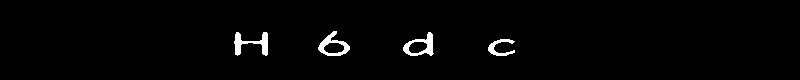

Epoch [1/5] Batch 85/121 Loss D: 1.2884, Loss G: 1.0989
Epoch [1/5] Batch 86/121 Loss D: 1.2637, Loss G: 1.1466
Epoch [1/5] Batch 87/121 Loss D: 1.3070, Loss G: 1.1526
Epoch [1/5] Batch 88/121 Loss D: 1.2390, Loss G: 1.1775
Epoch [1/5] Batch 89/121 Loss D: 1.2770, Loss G: 1.1915


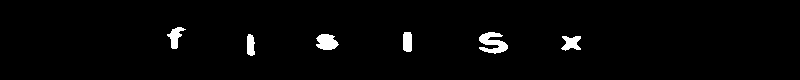

Epoch [1/5] Batch 90/121 Loss D: 1.1263, Loss G: 1.2240
Epoch [1/5] Batch 91/121 Loss D: 1.1890, Loss G: 1.1782
Epoch [1/5] Batch 92/121 Loss D: 1.2601, Loss G: 1.1044
Epoch [1/5] Batch 93/121 Loss D: 1.1511, Loss G: 1.1218
Epoch [1/5] Batch 94/121 Loss D: 1.2044, Loss G: 1.1306


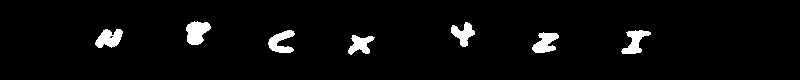

Epoch [1/5] Batch 95/121 Loss D: 1.2417, Loss G: 1.1400
Epoch [1/5] Batch 96/121 Loss D: 1.2958, Loss G: 1.0856
Epoch [1/5] Batch 97/121 Loss D: 1.2303, Loss G: 1.0648
Epoch [1/5] Batch 98/121 Loss D: 1.1248, Loss G: 1.1458
Epoch [1/5] Batch 99/121 Loss D: 1.2192, Loss G: 1.1671


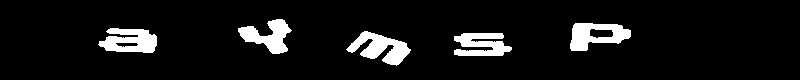

Epoch [1/5] Batch 100/121 Loss D: 1.2663, Loss G: 1.1878
Epoch [1/5] Batch 101/121 Loss D: 1.3172, Loss G: 1.1824
Epoch [1/5] Batch 102/121 Loss D: 1.1046, Loss G: 1.1527
Epoch [1/5] Batch 103/121 Loss D: 1.2947, Loss G: 1.0287
Epoch [1/5] Batch 104/121 Loss D: 1.1286, Loss G: 1.0893


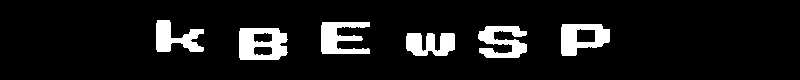

Epoch [1/5] Batch 105/121 Loss D: 1.0253, Loss G: 1.2141
Epoch [1/5] Batch 106/121 Loss D: 1.2563, Loss G: 1.1550
Epoch [1/5] Batch 107/121 Loss D: 1.2587, Loss G: 1.1382
Epoch [1/5] Batch 108/121 Loss D: 1.2593, Loss G: 1.1547
Epoch [1/5] Batch 109/121 Loss D: 1.1918, Loss G: 1.1048


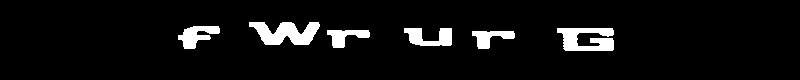

Epoch [1/5] Batch 110/121 Loss D: 1.1551, Loss G: 1.1140
Epoch [1/5] Batch 111/121 Loss D: 1.1830, Loss G: 1.1149
Epoch [1/5] Batch 112/121 Loss D: 1.2654, Loss G: 1.1083
Epoch [1/5] Batch 113/121 Loss D: 1.1622, Loss G: 1.1241
Epoch [1/5] Batch 114/121 Loss D: 1.1387, Loss G: 1.1590


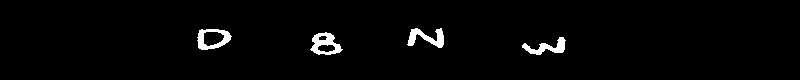

Epoch [1/5] Batch 115/121 Loss D: 1.1278, Loss G: 1.1735
Epoch [1/5] Batch 116/121 Loss D: 1.2498, Loss G: 1.1497
Epoch [1/5] Batch 117/121 Loss D: 1.0492, Loss G: 1.1340
Epoch [1/5] Batch 118/121 Loss D: 1.2019, Loss G: 1.1311
Epoch [1/5] Batch 119/121 Loss D: 1.0938, Loss G: 1.1520


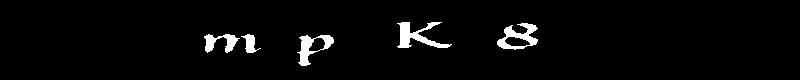

Epoch [1/5] Batch 120/121 Loss D: 1.3148, Loss G: 0.9813


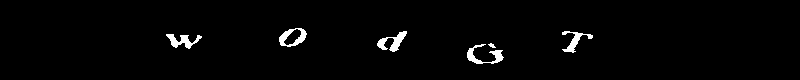

Epoch [2/5] Batch 0/121 Loss D: 1.1837, Loss G: 1.2322
Epoch [2/5] Batch 1/121 Loss D: 1.1663, Loss G: 1.1769
Epoch [2/5] Batch 2/121 Loss D: 1.2784, Loss G: 1.1310
Epoch [2/5] Batch 3/121 Loss D: 1.1868, Loss G: 1.1198
Epoch [2/5] Batch 4/121 Loss D: 1.1442, Loss G: 1.1502


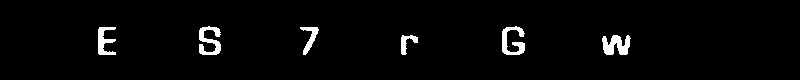

Epoch [2/5] Batch 5/121 Loss D: 1.0868, Loss G: 1.1691
Epoch [2/5] Batch 6/121 Loss D: 1.2019, Loss G: 1.1588
Epoch [2/5] Batch 7/121 Loss D: 1.2541, Loss G: 1.1114
Epoch [2/5] Batch 8/121 Loss D: 1.2966, Loss G: 1.1212
Epoch [2/5] Batch 9/121 Loss D: 1.1468, Loss G: 1.1955


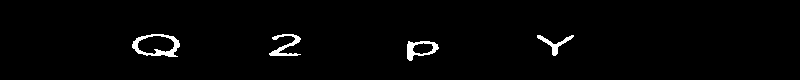

Epoch [2/5] Batch 10/121 Loss D: 1.1273, Loss G: 1.1482
Epoch [2/5] Batch 11/121 Loss D: 1.1204, Loss G: 1.2084
Epoch [2/5] Batch 12/121 Loss D: 1.1799, Loss G: 1.1775
Epoch [2/5] Batch 13/121 Loss D: 1.0863, Loss G: 1.1520
Epoch [2/5] Batch 14/121 Loss D: 1.2958, Loss G: 1.1228


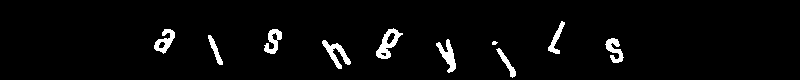

Epoch [2/5] Batch 15/121 Loss D: 1.1650, Loss G: 1.1217
Epoch [2/5] Batch 16/121 Loss D: 1.2408, Loss G: 1.0772
Epoch [2/5] Batch 17/121 Loss D: 1.2299, Loss G: 1.0795
Epoch [2/5] Batch 18/121 Loss D: 1.2099, Loss G: 1.0848
Epoch [2/5] Batch 19/121 Loss D: 1.0503, Loss G: 1.1440


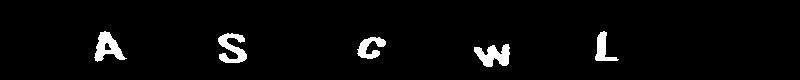

Epoch [2/5] Batch 20/121 Loss D: 1.2824, Loss G: 1.1037
Epoch [2/5] Batch 21/121 Loss D: 1.1168, Loss G: 1.1877
Epoch [2/5] Batch 22/121 Loss D: 1.2116, Loss G: 1.1304
Epoch [2/5] Batch 23/121 Loss D: 1.2297, Loss G: 1.1396
Epoch [2/5] Batch 24/121 Loss D: 1.1085, Loss G: 1.1734


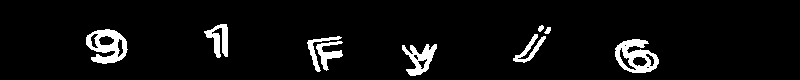

Epoch [2/5] Batch 25/121 Loss D: 1.1226, Loss G: 1.1810
Epoch [2/5] Batch 26/121 Loss D: 1.1898, Loss G: 1.1425
Epoch [2/5] Batch 27/121 Loss D: 1.1207, Loss G: 1.1708
Epoch [2/5] Batch 28/121 Loss D: 1.1182, Loss G: 1.1627
Epoch [2/5] Batch 29/121 Loss D: 1.2308, Loss G: 1.1411


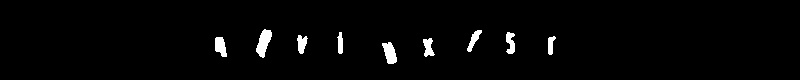

Epoch [2/5] Batch 30/121 Loss D: 1.2712, Loss G: 1.0748
Epoch [2/5] Batch 31/121 Loss D: 1.1537, Loss G: 1.1080
Epoch [2/5] Batch 32/121 Loss D: 1.1884, Loss G: 1.1750
Epoch [2/5] Batch 33/121 Loss D: 1.1396, Loss G: 1.1605
Epoch [2/5] Batch 34/121 Loss D: 1.1179, Loss G: 1.1368


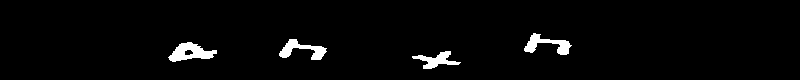

Epoch [2/5] Batch 35/121 Loss D: 1.1978, Loss G: 1.1853
Epoch [2/5] Batch 36/121 Loss D: 1.2898, Loss G: 1.1568
Epoch [2/5] Batch 37/121 Loss D: 1.2303, Loss G: 1.1616
Epoch [2/5] Batch 38/121 Loss D: 1.0900, Loss G: 1.1315
Epoch [2/5] Batch 39/121 Loss D: 1.1671, Loss G: 1.1204


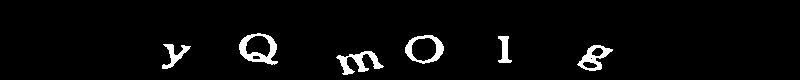

Epoch [2/5] Batch 40/121 Loss D: 1.2778, Loss G: 1.0919
Epoch [2/5] Batch 41/121 Loss D: 1.2084, Loss G: 1.1566
Epoch [2/5] Batch 42/121 Loss D: 1.1882, Loss G: 1.1209
Epoch [2/5] Batch 43/121 Loss D: 1.1434, Loss G: 1.1252
Epoch [2/5] Batch 44/121 Loss D: 1.1572, Loss G: 1.1342


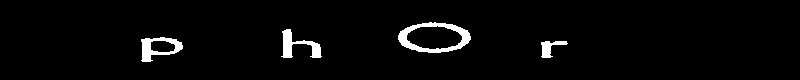

Epoch [2/5] Batch 45/121 Loss D: 1.2305, Loss G: 1.1161
Epoch [2/5] Batch 46/121 Loss D: 1.2968, Loss G: 1.1172
Epoch [2/5] Batch 47/121 Loss D: 1.2069, Loss G: 1.1581
Epoch [2/5] Batch 48/121 Loss D: 1.1491, Loss G: 1.1577
Epoch [2/5] Batch 49/121 Loss D: 1.1572, Loss G: 1.1070


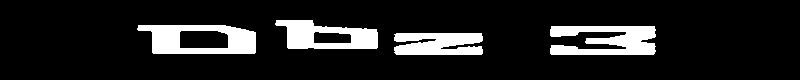

Epoch [2/5] Batch 50/121 Loss D: 1.1468, Loss G: 1.1709
Epoch [2/5] Batch 51/121 Loss D: 1.1057, Loss G: 1.1537
Epoch [2/5] Batch 52/121 Loss D: 1.0723, Loss G: 1.2221
Epoch [2/5] Batch 53/121 Loss D: 1.1340, Loss G: 1.2263
Epoch [2/5] Batch 54/121 Loss D: 1.3134, Loss G: 1.1216


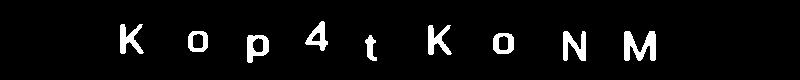

Epoch [2/5] Batch 55/121 Loss D: 1.1953, Loss G: 1.1873
Epoch [2/5] Batch 56/121 Loss D: 1.1401, Loss G: 1.1501
Epoch [2/5] Batch 57/121 Loss D: 1.2723, Loss G: 1.0779
Epoch [2/5] Batch 58/121 Loss D: 1.2409, Loss G: 1.1191
Epoch [2/5] Batch 59/121 Loss D: 1.1934, Loss G: 1.1109


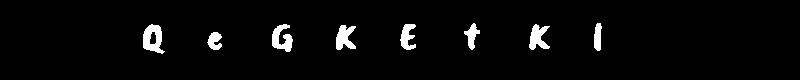

Epoch [2/5] Batch 60/121 Loss D: 1.0918, Loss G: 1.1447
Epoch [2/5] Batch 61/121 Loss D: 1.2073, Loss G: 1.1689
Epoch [2/5] Batch 62/121 Loss D: 1.2375, Loss G: 1.1377
Epoch [2/5] Batch 63/121 Loss D: 1.1832, Loss G: 1.1931
Epoch [2/5] Batch 64/121 Loss D: 1.1598, Loss G: 1.0934


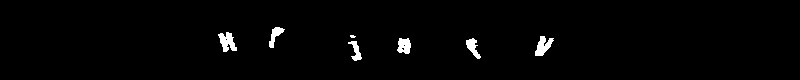

Epoch [2/5] Batch 65/121 Loss D: 1.1642, Loss G: 1.0997
Epoch [2/5] Batch 66/121 Loss D: 1.1230, Loss G: 1.1416
Epoch [2/5] Batch 67/121 Loss D: 1.1661, Loss G: 1.1394
Epoch [2/5] Batch 68/121 Loss D: 1.2372, Loss G: 1.0866
Epoch [2/5] Batch 69/121 Loss D: 1.0736, Loss G: 1.2462


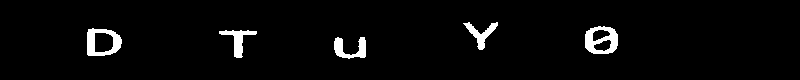

Epoch [2/5] Batch 70/121 Loss D: 1.0148, Loss G: 1.1948
Epoch [2/5] Batch 71/121 Loss D: 1.1203, Loss G: 1.2097
Epoch [2/5] Batch 72/121 Loss D: 1.4213, Loss G: 1.0613
Epoch [2/5] Batch 73/121 Loss D: 1.1894, Loss G: 1.1663
Epoch [2/5] Batch 74/121 Loss D: 1.1200, Loss G: 1.1893


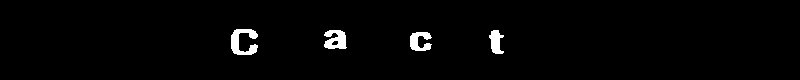

Epoch [2/5] Batch 75/121 Loss D: 1.1745, Loss G: 1.1801
Epoch [2/5] Batch 76/121 Loss D: 1.0986, Loss G: 1.1309
Epoch [2/5] Batch 77/121 Loss D: 1.1677, Loss G: 1.0846
Epoch [2/5] Batch 78/121 Loss D: 1.1860, Loss G: 1.1709
Epoch [2/5] Batch 79/121 Loss D: 1.1999, Loss G: 1.1735


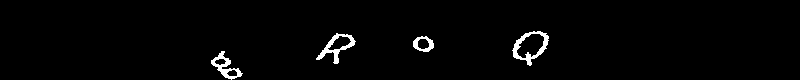

Epoch [2/5] Batch 80/121 Loss D: 1.2493, Loss G: 1.1453
Epoch [2/5] Batch 81/121 Loss D: 1.2228, Loss G: 1.1041
Epoch [2/5] Batch 82/121 Loss D: 1.1609, Loss G: 1.1715
Epoch [2/5] Batch 83/121 Loss D: 1.1605, Loss G: 1.1474
Epoch [2/5] Batch 84/121 Loss D: 1.2562, Loss G: 1.0827


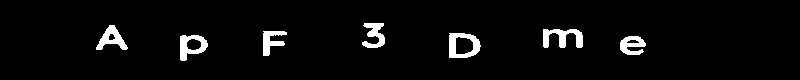

Epoch [2/5] Batch 85/121 Loss D: 1.1768, Loss G: 1.0866
Epoch [2/5] Batch 86/121 Loss D: 1.1478, Loss G: 1.1315
Epoch [2/5] Batch 87/121 Loss D: 1.1809, Loss G: 1.1282
Epoch [2/5] Batch 88/121 Loss D: 1.2052, Loss G: 1.1259
Epoch [2/5] Batch 89/121 Loss D: 1.2004, Loss G: 1.0647


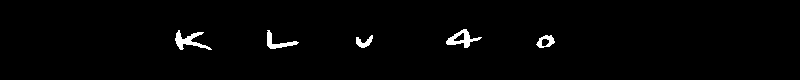

Epoch [2/5] Batch 90/121 Loss D: 1.2763, Loss G: 1.0676
Epoch [2/5] Batch 91/121 Loss D: 1.0800, Loss G: 1.1988
Epoch [2/5] Batch 92/121 Loss D: 1.2544, Loss G: 1.1327
Epoch [2/5] Batch 93/121 Loss D: 1.1244, Loss G: 1.1607
Epoch [2/5] Batch 94/121 Loss D: 1.1247, Loss G: 1.1767


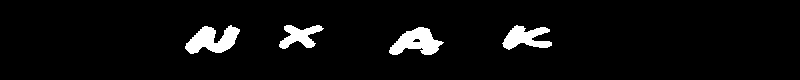

Epoch [2/5] Batch 95/121 Loss D: 1.2502, Loss G: 1.1547
Epoch [2/5] Batch 96/121 Loss D: 1.0269, Loss G: 1.1462
Epoch [2/5] Batch 97/121 Loss D: 1.1188, Loss G: 1.1559
Epoch [2/5] Batch 98/121 Loss D: 1.1894, Loss G: 1.1419
Epoch [2/5] Batch 99/121 Loss D: 1.2165, Loss G: 1.1213


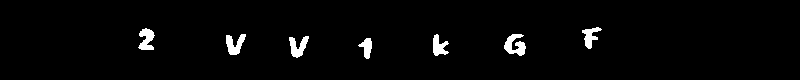

Epoch [2/5] Batch 100/121 Loss D: 1.1395, Loss G: 1.1218
Epoch [2/5] Batch 101/121 Loss D: 1.2289, Loss G: 1.1087
Epoch [2/5] Batch 102/121 Loss D: 1.1670, Loss G: 1.1663
Epoch [2/5] Batch 103/121 Loss D: 1.1903, Loss G: 1.1228
Epoch [2/5] Batch 104/121 Loss D: 1.1551, Loss G: 1.1521


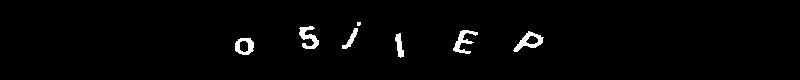

Epoch [2/5] Batch 105/121 Loss D: 1.1773, Loss G: 1.1246
Epoch [2/5] Batch 106/121 Loss D: 1.2195, Loss G: 1.1563
Epoch [2/5] Batch 107/121 Loss D: 1.3465, Loss G: 1.0032
Epoch [2/5] Batch 108/121 Loss D: 1.2666, Loss G: 1.0845
Epoch [2/5] Batch 109/121 Loss D: 1.1832, Loss G: 1.0931


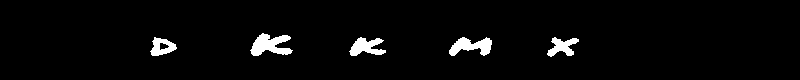

Epoch [2/5] Batch 110/121 Loss D: 1.2206, Loss G: 1.0587
Epoch [2/5] Batch 111/121 Loss D: 1.1055, Loss G: 1.1474
Epoch [2/5] Batch 112/121 Loss D: 1.1415, Loss G: 1.0925
Epoch [2/5] Batch 113/121 Loss D: 1.1183, Loss G: 1.2121
Epoch [2/5] Batch 114/121 Loss D: 1.2031, Loss G: 1.1434


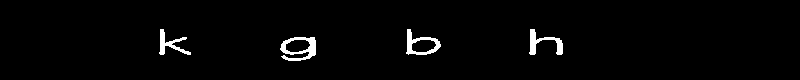

Epoch [2/5] Batch 115/121 Loss D: 1.2816, Loss G: 1.0494
Epoch [2/5] Batch 116/121 Loss D: 1.0618, Loss G: 1.1485
Epoch [2/5] Batch 117/121 Loss D: 1.1879, Loss G: 1.1128
Epoch [2/5] Batch 118/121 Loss D: 1.1494, Loss G: 1.1392
Epoch [2/5] Batch 119/121 Loss D: 1.1078, Loss G: 1.1390


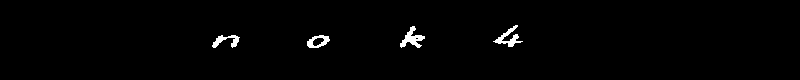

Epoch [2/5] Batch 120/121 Loss D: 1.1125, Loss G: 1.0968


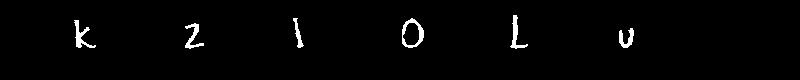

Epoch [3/5] Batch 0/121 Loss D: 1.0272, Loss G: 1.2341
Epoch [3/5] Batch 1/121 Loss D: 1.1157, Loss G: 1.2582
Epoch [3/5] Batch 2/121 Loss D: 1.1316, Loss G: 1.1844
Epoch [3/5] Batch 3/121 Loss D: 1.0483, Loss G: 1.1918
Epoch [3/5] Batch 4/121 Loss D: 1.1349, Loss G: 1.1285


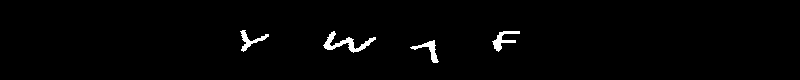

Epoch [3/5] Batch 5/121 Loss D: 1.1752, Loss G: 1.1430
Epoch [3/5] Batch 6/121 Loss D: 1.2621, Loss G: 1.0788
Epoch [3/5] Batch 7/121 Loss D: 1.1492, Loss G: 1.1246
Epoch [3/5] Batch 8/121 Loss D: 1.2978, Loss G: 1.0962
Epoch [3/5] Batch 9/121 Loss D: 1.0855, Loss G: 1.1919


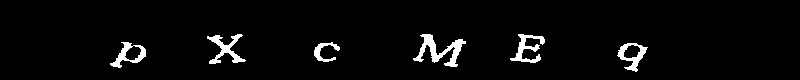

Epoch [3/5] Batch 10/121 Loss D: 1.1265, Loss G: 1.1152
Epoch [3/5] Batch 11/121 Loss D: 1.0639, Loss G: 1.1511
Epoch [3/5] Batch 12/121 Loss D: 1.0617, Loss G: 1.1922
Epoch [3/5] Batch 13/121 Loss D: 1.1579, Loss G: 1.1426
Epoch [3/5] Batch 14/121 Loss D: 1.1525, Loss G: 1.1751


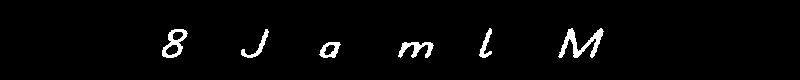

Epoch [3/5] Batch 15/121 Loss D: 1.0460, Loss G: 1.1966
Epoch [3/5] Batch 16/121 Loss D: 1.0970, Loss G: 1.1649
Epoch [3/5] Batch 17/121 Loss D: 1.0820, Loss G: 1.1323
Epoch [3/5] Batch 18/121 Loss D: 1.1057, Loss G: 1.1224
Epoch [3/5] Batch 19/121 Loss D: 1.0873, Loss G: 1.1911


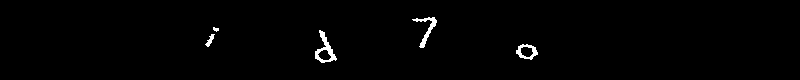

Epoch [3/5] Batch 20/121 Loss D: 1.1820, Loss G: 1.2143
Epoch [3/5] Batch 21/121 Loss D: 1.1677, Loss G: 1.1385
Epoch [3/5] Batch 22/121 Loss D: 1.1295, Loss G: 1.2321
Epoch [3/5] Batch 23/121 Loss D: 1.0897, Loss G: 1.1926
Epoch [3/5] Batch 24/121 Loss D: 1.0816, Loss G: 1.1488


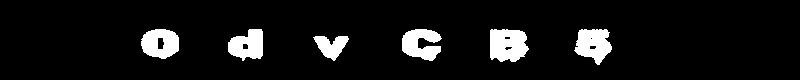

Epoch [3/5] Batch 25/121 Loss D: 1.1988, Loss G: 1.1434
Epoch [3/5] Batch 26/121 Loss D: 1.1920, Loss G: 1.0915
Epoch [3/5] Batch 27/121 Loss D: 1.1795, Loss G: 1.1292
Epoch [3/5] Batch 28/121 Loss D: 1.2557, Loss G: 1.1389
Epoch [3/5] Batch 29/121 Loss D: 1.2170, Loss G: 1.1862


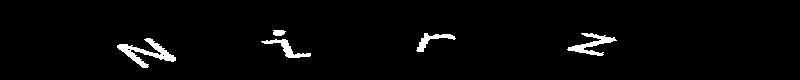

Epoch [3/5] Batch 30/121 Loss D: 1.0752, Loss G: 1.1090
Epoch [3/5] Batch 31/121 Loss D: 1.1241, Loss G: 1.2424
Epoch [3/5] Batch 32/121 Loss D: 1.0251, Loss G: 1.1971
Epoch [3/5] Batch 33/121 Loss D: 1.1201, Loss G: 1.1703
Epoch [3/5] Batch 34/121 Loss D: 1.1690, Loss G: 1.0948


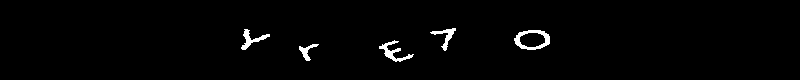

Epoch [3/5] Batch 35/121 Loss D: 1.1554, Loss G: 1.1548
Epoch [3/5] Batch 36/121 Loss D: 1.2494, Loss G: 1.1236
Epoch [3/5] Batch 37/121 Loss D: 1.0849, Loss G: 1.1824
Epoch [3/5] Batch 38/121 Loss D: 1.0305, Loss G: 1.2231
Epoch [3/5] Batch 39/121 Loss D: 1.1659, Loss G: 1.2302


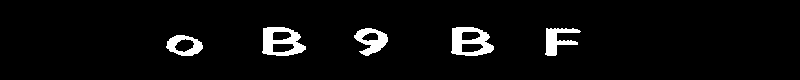

Epoch [3/5] Batch 40/121 Loss D: 1.1027, Loss G: 1.1312
Epoch [3/5] Batch 41/121 Loss D: 1.1516, Loss G: 1.1864
Epoch [3/5] Batch 42/121 Loss D: 1.0556, Loss G: 1.1869
Epoch [3/5] Batch 43/121 Loss D: 1.2395, Loss G: 1.0976
Epoch [3/5] Batch 44/121 Loss D: 1.1398, Loss G: 1.1891


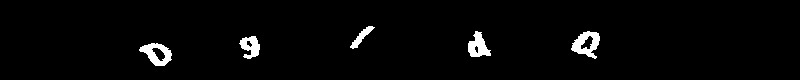

Epoch [3/5] Batch 45/121 Loss D: 1.0600, Loss G: 1.1793
Epoch [3/5] Batch 46/121 Loss D: 1.1353, Loss G: 1.2349
Epoch [3/5] Batch 47/121 Loss D: 1.2782, Loss G: 1.0993
Epoch [3/5] Batch 48/121 Loss D: 1.1102, Loss G: 1.1617
Epoch [3/5] Batch 49/121 Loss D: 1.1498, Loss G: 1.0681


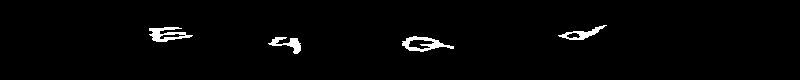

Epoch [3/5] Batch 50/121 Loss D: 1.0555, Loss G: 1.1565
Epoch [3/5] Batch 51/121 Loss D: 1.1251, Loss G: 1.2082
Epoch [3/5] Batch 52/121 Loss D: 1.1479, Loss G: 1.1113
Epoch [3/5] Batch 53/121 Loss D: 1.1154, Loss G: 1.2109
Epoch [3/5] Batch 54/121 Loss D: 1.1211, Loss G: 1.2112


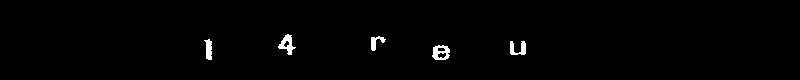

Epoch [3/5] Batch 55/121 Loss D: 1.2441, Loss G: 1.1492
Epoch [3/5] Batch 56/121 Loss D: 1.1599, Loss G: 1.1198
Epoch [3/5] Batch 57/121 Loss D: 1.1133, Loss G: 1.1267
Epoch [3/5] Batch 58/121 Loss D: 1.1768, Loss G: 1.1810
Epoch [3/5] Batch 59/121 Loss D: 1.1263, Loss G: 1.1931


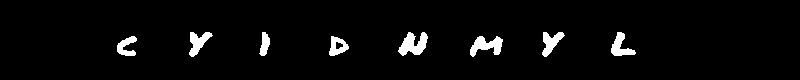

Epoch [3/5] Batch 60/121 Loss D: 1.2036, Loss G: 1.1592
Epoch [3/5] Batch 61/121 Loss D: 1.1445, Loss G: 1.1320
Epoch [3/5] Batch 62/121 Loss D: 1.1599, Loss G: 1.1066
Epoch [3/5] Batch 63/121 Loss D: 1.0524, Loss G: 1.1542
Epoch [3/5] Batch 64/121 Loss D: 1.1405, Loss G: 1.2188


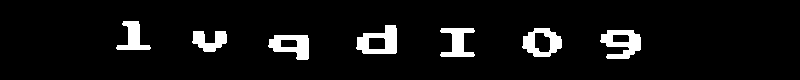

Epoch [3/5] Batch 65/121 Loss D: 1.1822, Loss G: 1.1420
Epoch [3/5] Batch 66/121 Loss D: 1.1650, Loss G: 1.2013
Epoch [3/5] Batch 67/121 Loss D: 1.2415, Loss G: 1.1423
Epoch [3/5] Batch 68/121 Loss D: 1.1817, Loss G: 1.1883
Epoch [3/5] Batch 69/121 Loss D: 1.1973, Loss G: 1.1153


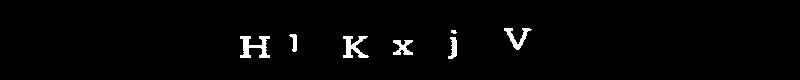

Epoch [3/5] Batch 70/121 Loss D: 1.0730, Loss G: 1.2379
Epoch [3/5] Batch 71/121 Loss D: 1.2010, Loss G: 1.1853
Epoch [3/5] Batch 72/121 Loss D: 1.1915, Loss G: 1.1322
Epoch [3/5] Batch 73/121 Loss D: 1.1817, Loss G: 1.1240
Epoch [3/5] Batch 74/121 Loss D: 1.1913, Loss G: 1.1250


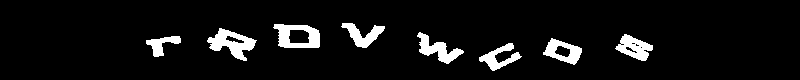

Epoch [3/5] Batch 75/121 Loss D: 1.0609, Loss G: 1.1690
Epoch [3/5] Batch 76/121 Loss D: 1.0313, Loss G: 1.1809
Epoch [3/5] Batch 77/121 Loss D: 1.1432, Loss G: 1.1657
Epoch [3/5] Batch 78/121 Loss D: 0.9917, Loss G: 1.2379
Epoch [3/5] Batch 79/121 Loss D: 1.1557, Loss G: 1.2243


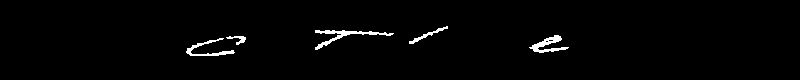

Epoch [3/5] Batch 80/121 Loss D: 1.0203, Loss G: 1.2743
Epoch [3/5] Batch 81/121 Loss D: 1.1380, Loss G: 1.1528
Epoch [3/5] Batch 82/121 Loss D: 1.1091, Loss G: 1.1841
Epoch [3/5] Batch 83/121 Loss D: 1.1128, Loss G: 1.1798
Epoch [3/5] Batch 84/121 Loss D: 1.2232, Loss G: 1.1240


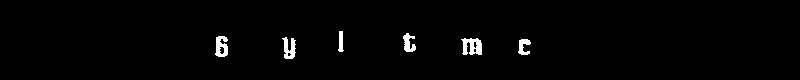

Epoch [3/5] Batch 85/121 Loss D: 1.1326, Loss G: 1.1762
Epoch [3/5] Batch 86/121 Loss D: 1.1246, Loss G: 1.2102
Epoch [3/5] Batch 87/121 Loss D: 1.1166, Loss G: 1.1796
Epoch [3/5] Batch 88/121 Loss D: 0.9540, Loss G: 1.2179
Epoch [3/5] Batch 89/121 Loss D: 1.1558, Loss G: 1.1683


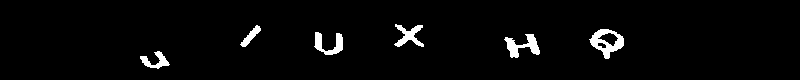

Epoch [3/5] Batch 90/121 Loss D: 1.1295, Loss G: 1.1833
Epoch [3/5] Batch 91/121 Loss D: 1.0741, Loss G: 1.2484
Epoch [3/5] Batch 92/121 Loss D: 0.9392, Loss G: 1.2450
Epoch [3/5] Batch 93/121 Loss D: 1.1240, Loss G: 1.3264
Epoch [3/5] Batch 94/121 Loss D: 1.1099, Loss G: 1.2005


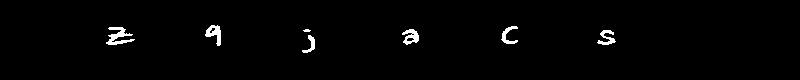

Epoch [3/5] Batch 95/121 Loss D: 1.0875, Loss G: 1.1769
Epoch [3/5] Batch 96/121 Loss D: 1.1252, Loss G: 1.1982
Epoch [3/5] Batch 97/121 Loss D: 1.1477, Loss G: 1.1876
Epoch [3/5] Batch 98/121 Loss D: 1.0598, Loss G: 1.2476
Epoch [3/5] Batch 99/121 Loss D: 1.1350, Loss G: 1.2176


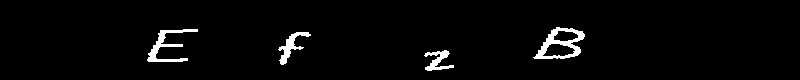

Epoch [3/5] Batch 100/121 Loss D: 1.1355, Loss G: 1.1820
Epoch [3/5] Batch 101/121 Loss D: 1.1805, Loss G: 1.1555
Epoch [3/5] Batch 102/121 Loss D: 1.1782, Loss G: 1.1682
Epoch [3/5] Batch 103/121 Loss D: 1.2356, Loss G: 1.1109
Epoch [3/5] Batch 104/121 Loss D: 1.1386, Loss G: 1.2320


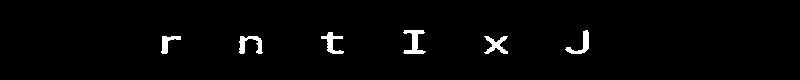

Epoch [3/5] Batch 105/121 Loss D: 1.2597, Loss G: 1.0936
Epoch [3/5] Batch 106/121 Loss D: 1.1582, Loss G: 1.1623
Epoch [3/5] Batch 107/121 Loss D: 1.1251, Loss G: 1.2175
Epoch [3/5] Batch 108/121 Loss D: 1.1267, Loss G: 1.1962
Epoch [3/5] Batch 109/121 Loss D: 1.1428, Loss G: 1.1683


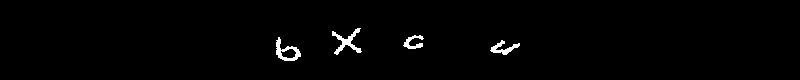

Epoch [3/5] Batch 110/121 Loss D: 1.0910, Loss G: 1.1521
Epoch [3/5] Batch 111/121 Loss D: 1.1258, Loss G: 1.2088
Epoch [3/5] Batch 112/121 Loss D: 1.2246, Loss G: 1.1391
Epoch [3/5] Batch 113/121 Loss D: 1.0989, Loss G: 1.1835
Epoch [3/5] Batch 114/121 Loss D: 1.2077, Loss G: 1.0914


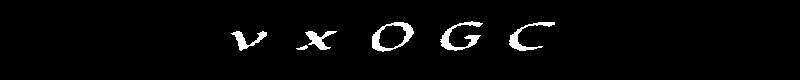

Epoch [3/5] Batch 115/121 Loss D: 1.0452, Loss G: 1.2202
Epoch [3/5] Batch 116/121 Loss D: 1.1996, Loss G: 1.1233
Epoch [3/5] Batch 117/121 Loss D: 1.1342, Loss G: 1.2163
Epoch [3/5] Batch 118/121 Loss D: 1.2434, Loss G: 1.2025
Epoch [3/5] Batch 119/121 Loss D: 1.0209, Loss G: 1.1809


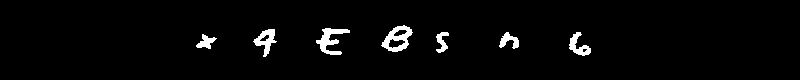

Epoch [3/5] Batch 120/121 Loss D: 1.1440, Loss G: 1.1049


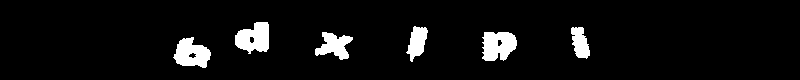

Epoch [4/5] Batch 0/121 Loss D: 1.0325, Loss G: 1.1841
Epoch [4/5] Batch 1/121 Loss D: 1.0610, Loss G: 1.2808
Epoch [4/5] Batch 2/121 Loss D: 1.1642, Loss G: 1.2017
Epoch [4/5] Batch 3/121 Loss D: 1.1081, Loss G: 1.1601
Epoch [4/5] Batch 4/121 Loss D: 1.0818, Loss G: 1.1639


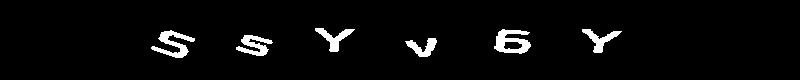

Epoch [4/5] Batch 5/121 Loss D: 1.1468, Loss G: 1.1226
Epoch [4/5] Batch 6/121 Loss D: 1.0630, Loss G: 1.1764
Epoch [4/5] Batch 7/121 Loss D: 1.2534, Loss G: 1.1543
Epoch [4/5] Batch 8/121 Loss D: 1.2962, Loss G: 1.1054
Epoch [4/5] Batch 9/121 Loss D: 1.1077, Loss G: 1.1051


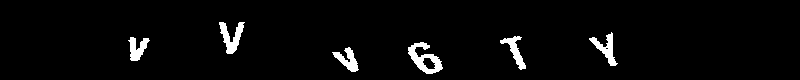

Epoch [4/5] Batch 10/121 Loss D: 1.1499, Loss G: 1.1406
Epoch [4/5] Batch 11/121 Loss D: 1.1512, Loss G: 1.2134
Epoch [4/5] Batch 12/121 Loss D: 1.0649, Loss G: 1.1791
Epoch [4/5] Batch 13/121 Loss D: 1.1520, Loss G: 1.2429
Epoch [4/5] Batch 14/121 Loss D: 1.0726, Loss G: 1.3167


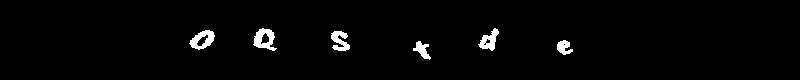

Epoch [4/5] Batch 15/121 Loss D: 1.1283, Loss G: 1.1824
Epoch [4/5] Batch 16/121 Loss D: 1.0757, Loss G: 1.1965
Epoch [4/5] Batch 17/121 Loss D: 1.2217, Loss G: 1.1076
Epoch [4/5] Batch 18/121 Loss D: 1.0718, Loss G: 1.1915
Epoch [4/5] Batch 19/121 Loss D: 1.1049, Loss G: 1.1632


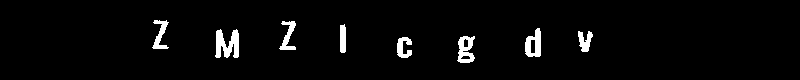

Epoch [4/5] Batch 20/121 Loss D: 1.0984, Loss G: 1.1464
Epoch [4/5] Batch 21/121 Loss D: 1.2121, Loss G: 1.1392
Epoch [4/5] Batch 22/121 Loss D: 1.2162, Loss G: 1.1486
Epoch [4/5] Batch 23/121 Loss D: 1.1574, Loss G: 1.2311
Epoch [4/5] Batch 24/121 Loss D: 1.1078, Loss G: 1.1872


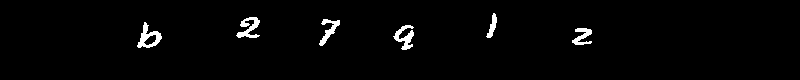

Epoch [4/5] Batch 25/121 Loss D: 1.0491, Loss G: 1.1992
Epoch [4/5] Batch 26/121 Loss D: 1.2580, Loss G: 1.0858
Epoch [4/5] Batch 27/121 Loss D: 1.1505, Loss G: 1.2172
Epoch [4/5] Batch 28/121 Loss D: 0.9917, Loss G: 1.2079
Epoch [4/5] Batch 29/121 Loss D: 1.2022, Loss G: 1.1907


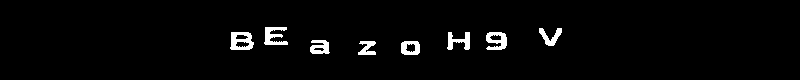

Epoch [4/5] Batch 30/121 Loss D: 1.1309, Loss G: 1.1338
Epoch [4/5] Batch 31/121 Loss D: 1.0531, Loss G: 1.2248
Epoch [4/5] Batch 32/121 Loss D: 1.1887, Loss G: 1.1142
Epoch [4/5] Batch 33/121 Loss D: 1.1308, Loss G: 1.2065
Epoch [4/5] Batch 34/121 Loss D: 1.1535, Loss G: 1.1493


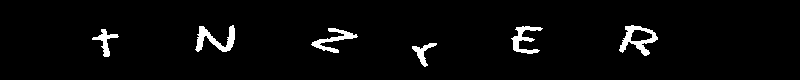

Epoch [4/5] Batch 35/121 Loss D: 1.2006, Loss G: 1.1054
Epoch [4/5] Batch 36/121 Loss D: 1.2338, Loss G: 1.0622
Epoch [4/5] Batch 37/121 Loss D: 1.0760, Loss G: 1.2447
Epoch [4/5] Batch 38/121 Loss D: 1.0927, Loss G: 1.2001
Epoch [4/5] Batch 39/121 Loss D: 1.0645, Loss G: 1.1596


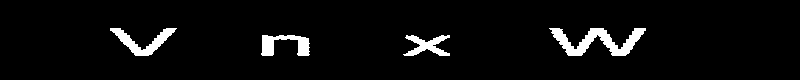

Epoch [4/5] Batch 40/121 Loss D: 1.1657, Loss G: 1.1839
Epoch [4/5] Batch 41/121 Loss D: 1.1751, Loss G: 1.1548
Epoch [4/5] Batch 42/121 Loss D: 1.1262, Loss G: 1.1452
Epoch [4/5] Batch 43/121 Loss D: 1.1920, Loss G: 1.1566
Epoch [4/5] Batch 44/121 Loss D: 1.0173, Loss G: 1.2797


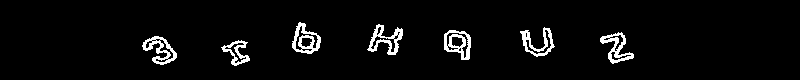

Epoch [4/5] Batch 45/121 Loss D: 1.0885, Loss G: 1.2333
Epoch [4/5] Batch 46/121 Loss D: 1.0526, Loss G: 1.1685
Epoch [4/5] Batch 47/121 Loss D: 1.0495, Loss G: 1.1981
Epoch [4/5] Batch 48/121 Loss D: 1.0653, Loss G: 1.2127
Epoch [4/5] Batch 49/121 Loss D: 1.1160, Loss G: 1.2842


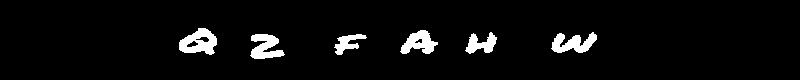

Epoch [4/5] Batch 50/121 Loss D: 1.0745, Loss G: 1.2276
Epoch [4/5] Batch 51/121 Loss D: 1.1536, Loss G: 1.2059
Epoch [4/5] Batch 52/121 Loss D: 1.1005, Loss G: 1.2287
Epoch [4/5] Batch 53/121 Loss D: 1.1011, Loss G: 1.1160
Epoch [4/5] Batch 54/121 Loss D: 1.0604, Loss G: 1.1868


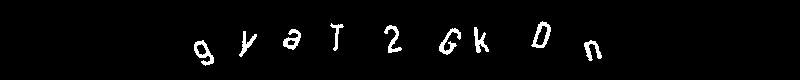

Epoch [4/5] Batch 55/121 Loss D: 1.0968, Loss G: 1.1775
Epoch [4/5] Batch 56/121 Loss D: 1.1455, Loss G: 1.1655
Epoch [4/5] Batch 57/121 Loss D: 1.0511, Loss G: 1.2519
Epoch [4/5] Batch 58/121 Loss D: 1.0561, Loss G: 1.2352
Epoch [4/5] Batch 59/121 Loss D: 1.1636, Loss G: 1.2000


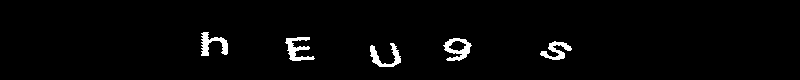

Epoch [4/5] Batch 60/121 Loss D: 1.1117, Loss G: 1.1110
Epoch [4/5] Batch 61/121 Loss D: 1.1221, Loss G: 1.1880
Epoch [4/5] Batch 62/121 Loss D: 1.0460, Loss G: 1.2794
Epoch [4/5] Batch 63/121 Loss D: 1.1971, Loss G: 1.1736
Epoch [4/5] Batch 64/121 Loss D: 0.9590, Loss G: 1.3589


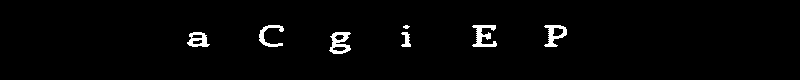

Epoch [4/5] Batch 65/121 Loss D: 1.2549, Loss G: 1.1749
Epoch [4/5] Batch 66/121 Loss D: 1.2459, Loss G: 1.1191
Epoch [4/5] Batch 67/121 Loss D: 1.1638, Loss G: 1.1308
Epoch [4/5] Batch 68/121 Loss D: 1.0526, Loss G: 1.1561
Epoch [4/5] Batch 69/121 Loss D: 1.0037, Loss G: 1.2439


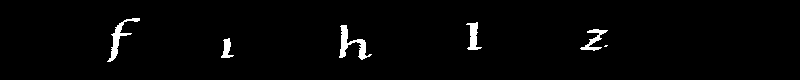

Epoch [4/5] Batch 70/121 Loss D: 0.9975, Loss G: 1.2992
Epoch [4/5] Batch 71/121 Loss D: 1.0133, Loss G: 1.2478
Epoch [4/5] Batch 72/121 Loss D: 1.1578, Loss G: 1.1584
Epoch [4/5] Batch 73/121 Loss D: 1.1107, Loss G: 1.2268
Epoch [4/5] Batch 74/121 Loss D: 1.1730, Loss G: 1.1108


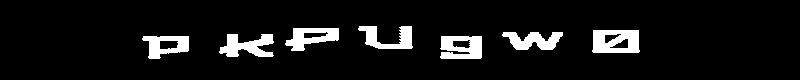

Epoch [4/5] Batch 75/121 Loss D: 1.0578, Loss G: 1.1909
Epoch [4/5] Batch 76/121 Loss D: 1.1121, Loss G: 1.2020
Epoch [4/5] Batch 77/121 Loss D: 1.1516, Loss G: 1.1303
Epoch [4/5] Batch 78/121 Loss D: 1.1805, Loss G: 1.0864
Epoch [4/5] Batch 79/121 Loss D: 1.0604, Loss G: 1.1957


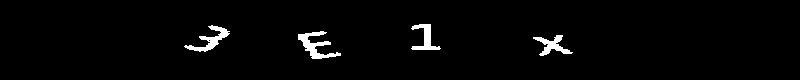

Epoch [4/5] Batch 80/121 Loss D: 1.0826, Loss G: 1.1617
Epoch [4/5] Batch 81/121 Loss D: 1.0208, Loss G: 1.2829
Epoch [4/5] Batch 82/121 Loss D: 1.1045, Loss G: 1.1892
Epoch [4/5] Batch 83/121 Loss D: 1.0624, Loss G: 1.1980
Epoch [4/5] Batch 84/121 Loss D: 0.9634, Loss G: 1.3795


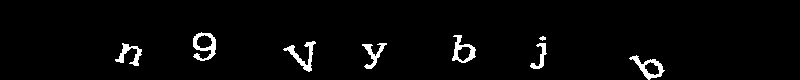

Epoch [4/5] Batch 85/121 Loss D: 1.0402, Loss G: 1.1660
Epoch [4/5] Batch 86/121 Loss D: 0.9782, Loss G: 1.2354
Epoch [4/5] Batch 87/121 Loss D: 1.0782, Loss G: 1.1794
Epoch [4/5] Batch 88/121 Loss D: 1.2077, Loss G: 1.1409
Epoch [4/5] Batch 89/121 Loss D: 1.1355, Loss G: 1.2670


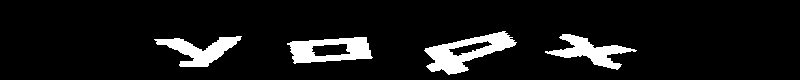

Epoch [4/5] Batch 90/121 Loss D: 1.2035, Loss G: 1.1738
Epoch [4/5] Batch 91/121 Loss D: 1.1074, Loss G: 1.0760
Epoch [4/5] Batch 92/121 Loss D: 1.1004, Loss G: 1.2365
Epoch [4/5] Batch 93/121 Loss D: 1.1567, Loss G: 1.2704
Epoch [4/5] Batch 94/121 Loss D: 1.2243, Loss G: 1.1490


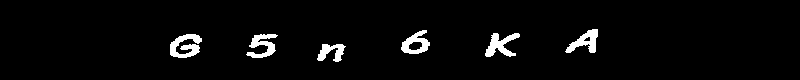

Epoch [4/5] Batch 95/121 Loss D: 1.0678, Loss G: 1.1990
Epoch [4/5] Batch 96/121 Loss D: 1.0097, Loss G: 1.1962
Epoch [4/5] Batch 97/121 Loss D: 1.0761, Loss G: 1.2586
Epoch [4/5] Batch 98/121 Loss D: 1.0331, Loss G: 1.2994
Epoch [4/5] Batch 99/121 Loss D: 1.1623, Loss G: 1.1600


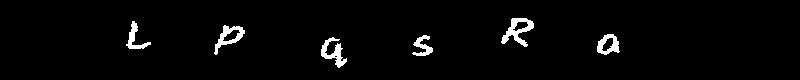

Epoch [4/5] Batch 100/121 Loss D: 0.9221, Loss G: 1.2733
Epoch [4/5] Batch 101/121 Loss D: 1.0418, Loss G: 1.3181
Epoch [4/5] Batch 102/121 Loss D: 1.2181, Loss G: 1.2121
Epoch [4/5] Batch 103/121 Loss D: 1.0982, Loss G: 1.1934
Epoch [4/5] Batch 104/121 Loss D: 1.0588, Loss G: 1.1868


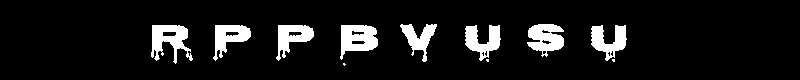

Epoch [4/5] Batch 105/121 Loss D: 1.0192, Loss G: 1.2582
Epoch [4/5] Batch 106/121 Loss D: 1.0452, Loss G: 1.2262
Epoch [4/5] Batch 107/121 Loss D: 0.9562, Loss G: 1.2430
Epoch [4/5] Batch 108/121 Loss D: 1.0603, Loss G: 1.2132
Epoch [4/5] Batch 109/121 Loss D: 1.0729, Loss G: 1.2173


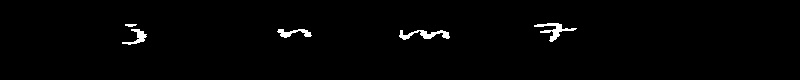

Epoch [4/5] Batch 110/121 Loss D: 1.0827, Loss G: 1.1837
Epoch [4/5] Batch 111/121 Loss D: 1.1427, Loss G: 1.2205
Epoch [4/5] Batch 112/121 Loss D: 1.2596, Loss G: 1.1977
Epoch [4/5] Batch 113/121 Loss D: 1.1906, Loss G: 1.1770
Epoch [4/5] Batch 114/121 Loss D: 0.9383, Loss G: 1.2923


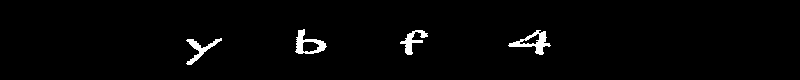

Epoch [4/5] Batch 115/121 Loss D: 1.2976, Loss G: 1.1881
Epoch [4/5] Batch 116/121 Loss D: 1.0321, Loss G: 1.2702
Epoch [4/5] Batch 117/121 Loss D: 1.1117, Loss G: 1.1752
Epoch [4/5] Batch 118/121 Loss D: 1.1257, Loss G: 1.1951
Epoch [4/5] Batch 119/121 Loss D: 1.0442, Loss G: 1.2618


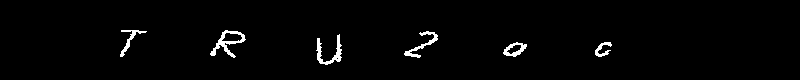

Epoch [4/5] Batch 120/121 Loss D: 1.0181, Loss G: 1.1687


In [41]:
for epoch in range(num_epochs):
    for i, images in enumerate(dataloader):
        real_imgs = images.to(device)
        b_size = real_imgs.size(0)

        # Labels
        y_true_real = torch.full((b_size, 1), 1.0, device=device)
        y_true_fake = torch.full((b_size, 1), 0.0, device=device)

        # Fake images
        fake_imgs = [transform(generate_random_captcha()) for _ in range(b_size)]
        fake_imgs = torch.stack(fake_imgs).reshape(b_size, 1, 80, 800).to(device)
        fake_imgs_refined = netG(fake_imgs) # go through generator to apply pixel-level adjustments

        if not i % 5:
            display_image(fake_imgs_refined[0].cpu().detach())

        # ---- Train Discriminator ----

        # Real images
        y_pred_real = netD(real_imgs).view(-1, 1)
        lossD_real = criterion(y_pred_real, y_true_real)
        y_pred_fake = netD(fake_imgs_refined.detach()).view(-1, 1)
        lossD_fake = criterion(y_pred_fake, y_true_fake)

        lossD = lossD_real + lossD_fake

        netD.zero_grad()
        optimizerD.zero_grad()
        lossD.backward()
        optimizerD.step()

        # ---- Train Generator ----
        netG.zero_grad()
        netD.zero_grad()
        optimizerG.zero_grad()

        # Try to fool the discriminator
        y_pred_fake_for_G = netD(fake_imgs_refined).view(-1, 1)
        lossG_bce = criterion(y_pred_fake_for_G, y_true_real)
        lossG_self_reg = self_regularisation_loss(fake_imgs_refined, fake_imgs)
        lossG = lossG_bce + lossG_self_reg
        lossG.backward()
        optimizerG.step()

        if i % 1 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(dataloader)} "
                  f"Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}")

tensor([[[[0.4672]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


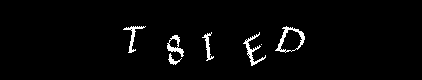

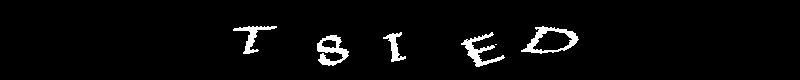

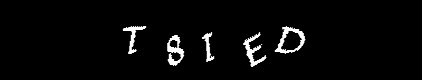

tensor([[[[0.5115]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


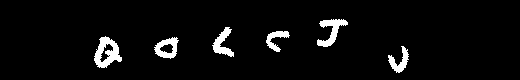

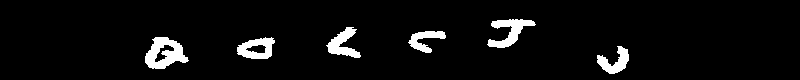

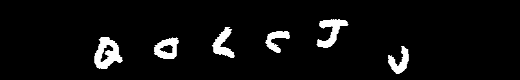

tensor([[[[0.2730]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3772]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2964]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3110]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4890]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


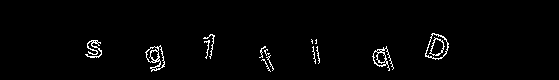

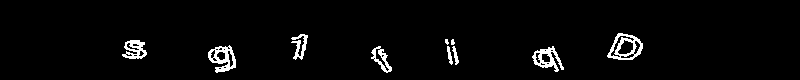

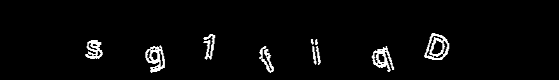

tensor([[[[0.1710]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3288]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4782]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


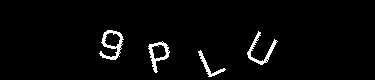

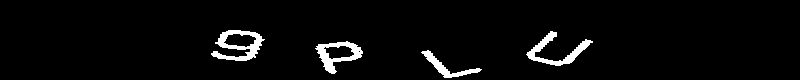

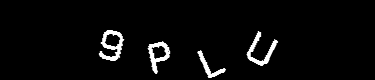

tensor([[[[0.3336]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1648]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5048]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


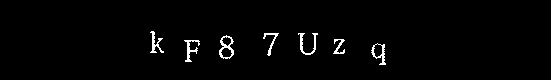

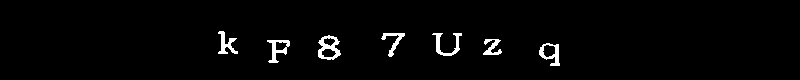

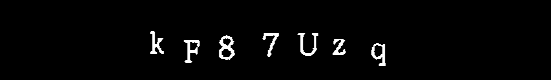

tensor([[[[0.5581]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


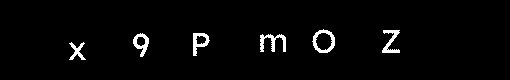

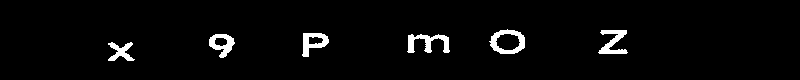

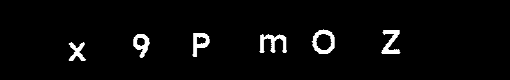

tensor([[[[0.4782]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


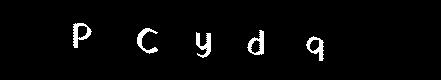

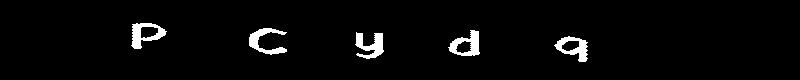

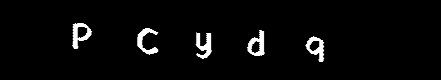

tensor([[[[0.3643]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4388]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


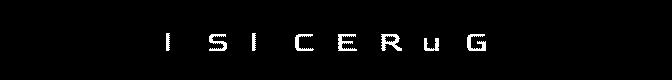

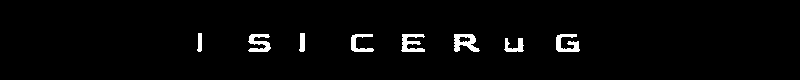

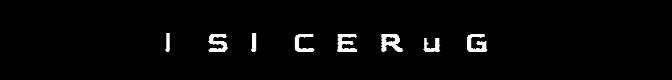

tensor([[[[0.2724]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1976]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2769]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4432]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


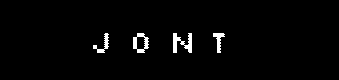

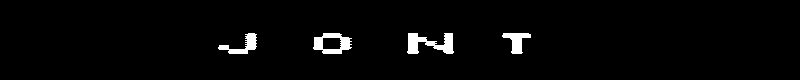

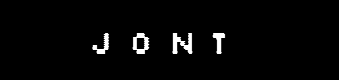

tensor([[[[0.9057]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


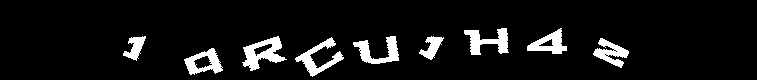

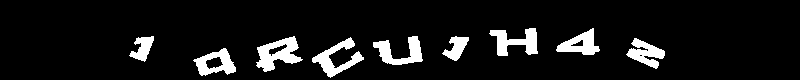

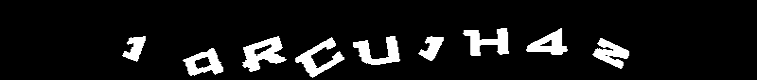

tensor([[[[0.2887]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6310]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


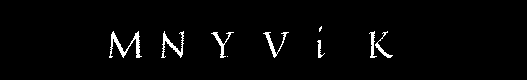

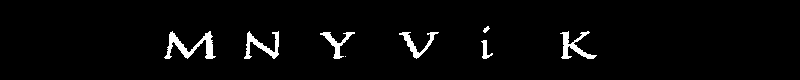

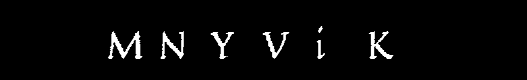

tensor([[[[0.0904]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2065]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6563]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


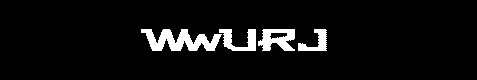

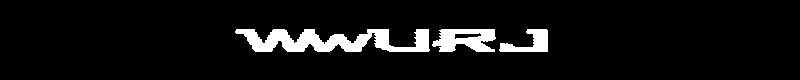

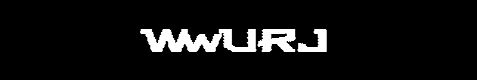

tensor([[[[0.3983]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4755]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


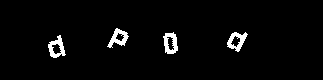

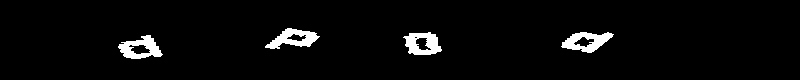

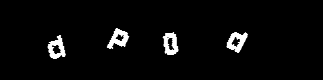

tensor([[[[0.1648]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6403]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


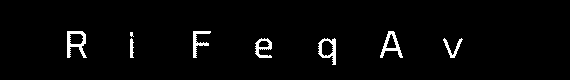

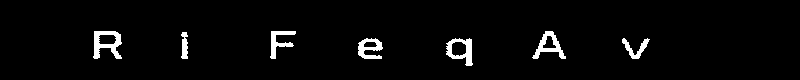

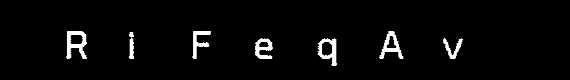

tensor([[[[0.3110]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4234]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


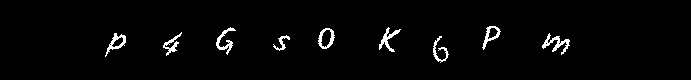

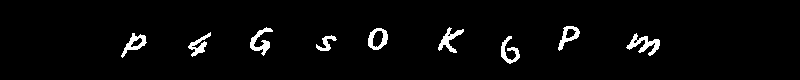

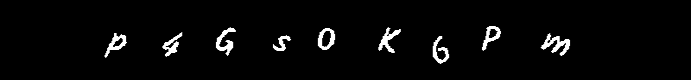

tensor([[[[0.2255]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3327]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4128]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


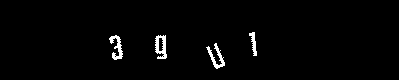

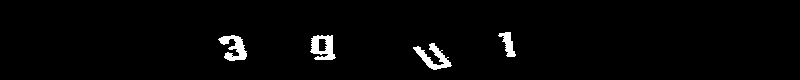

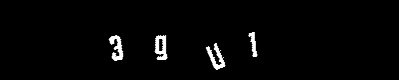

tensor([[[[0.6913]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


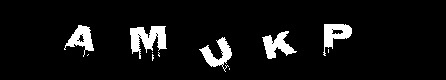

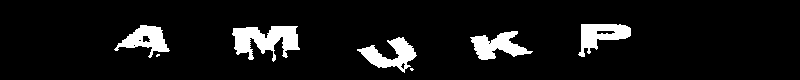

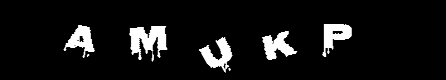

tensor([[[[0.5090]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


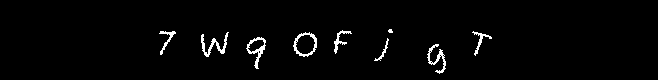

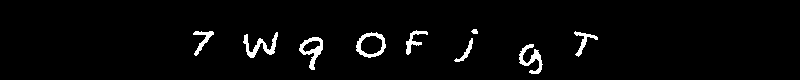

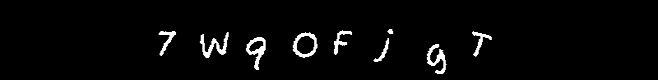

tensor([[[[0.5317]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


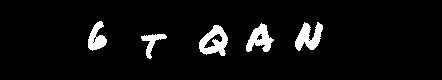

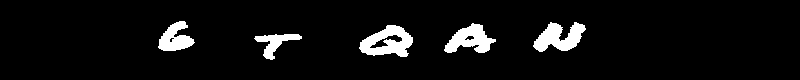

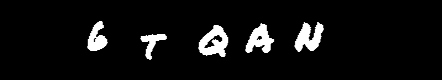

tensor([[[[0.1842]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3868]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.9239]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


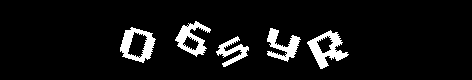

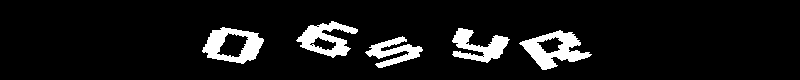

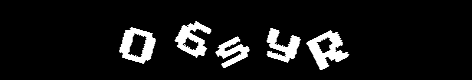

tensor([[[[0.3695]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2717]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3195]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3241]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1877]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4585]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


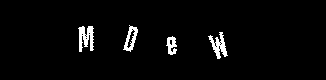

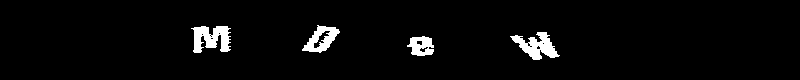

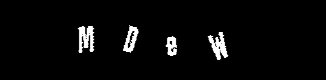

tensor([[[[0.4560]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


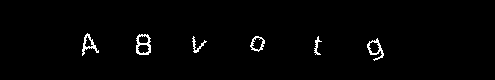

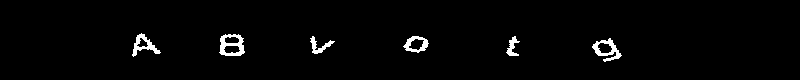

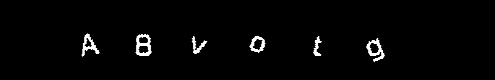

tensor([[[[0.5143]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


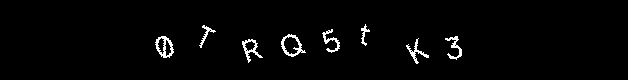

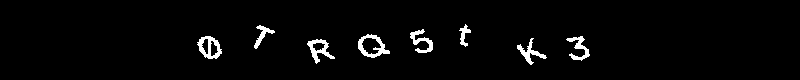

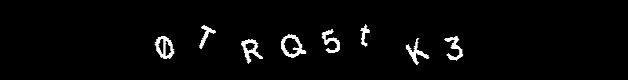

tensor([[[[0.6818]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


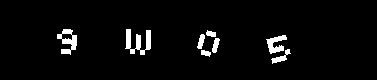

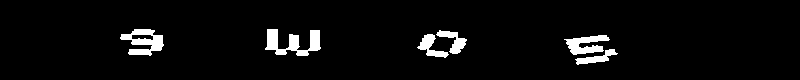

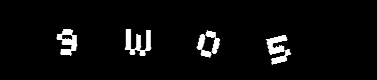

tensor([[[[0.3248]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2644]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1677]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2360]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1591]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.7022]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


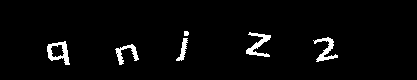

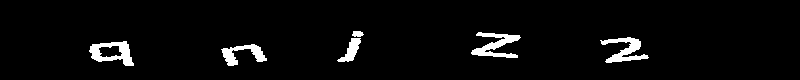

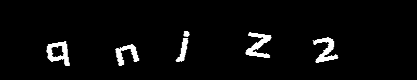

tensor([[[[0.7853]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


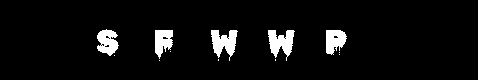

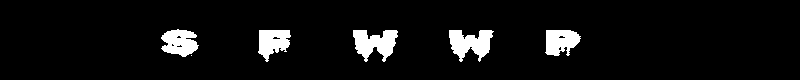

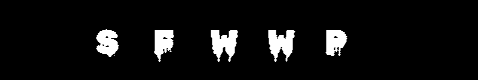

tensor([[[[0.1179]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1493]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3312]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2295]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3114]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2610]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1765]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1436]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6523]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


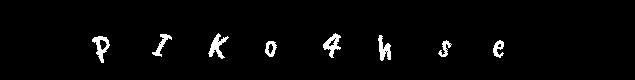

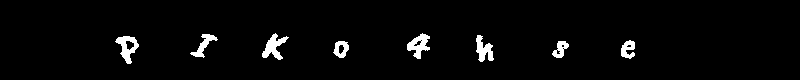

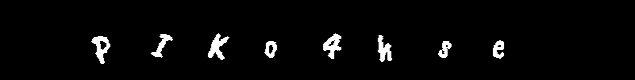

tensor([[[[0.3736]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3238]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3932]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3599]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4121]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


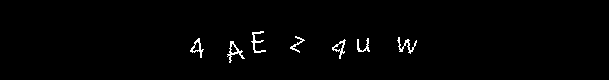

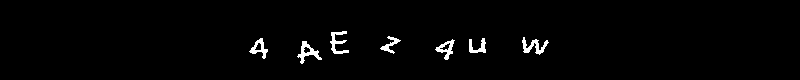

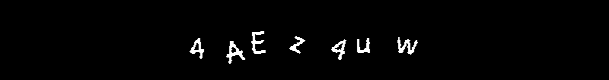

tensor([[[[0.2218]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5495]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


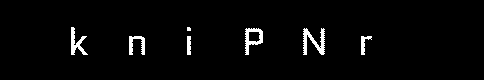

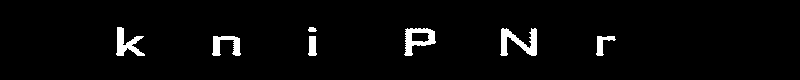

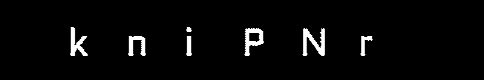

tensor([[[[0.3120]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4071]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


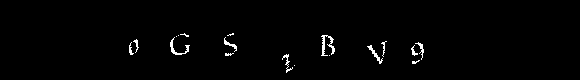

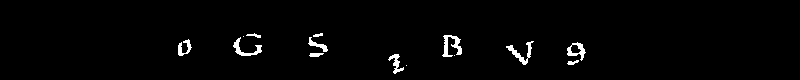

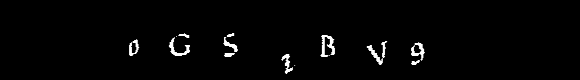

tensor([[[[0.6243]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


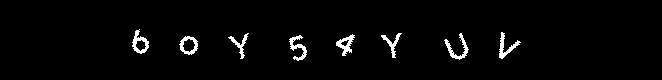

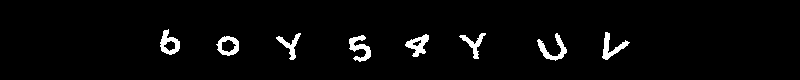

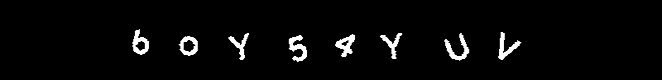

tensor([[[[0.2004]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.8155]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


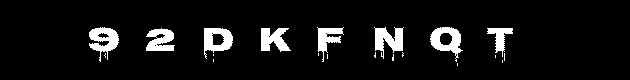

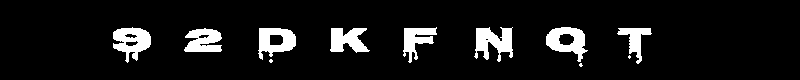

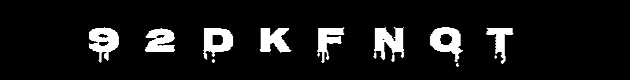

tensor([[[[0.1614]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2048]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1766]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5637]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


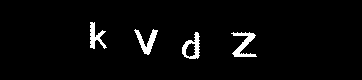

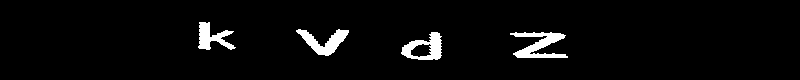

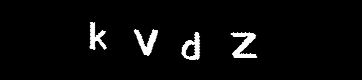

tensor([[[[0.7177]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


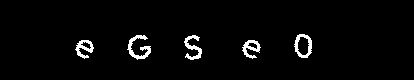

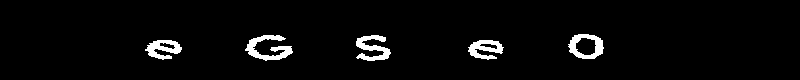

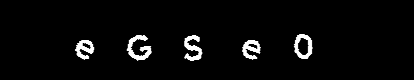

tensor([[[[0.5012]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


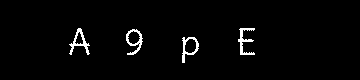

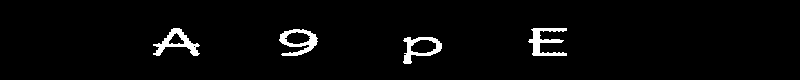

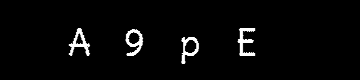

tensor([[[[0.1256]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3058]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5043]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


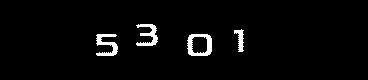

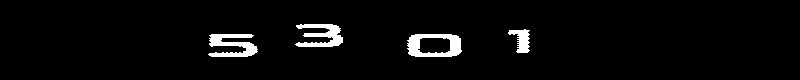

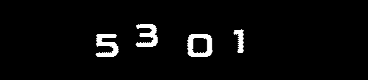

tensor([[[[0.8585]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


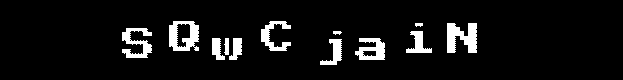

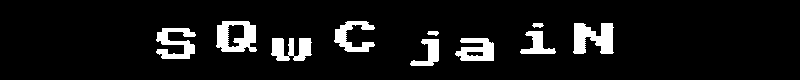

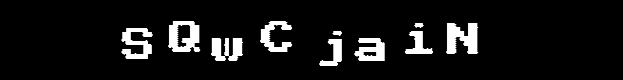

tensor([[[[0.1907]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2650]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2329]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6079]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


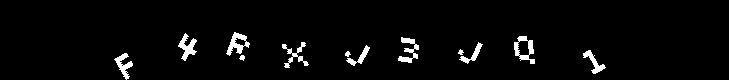

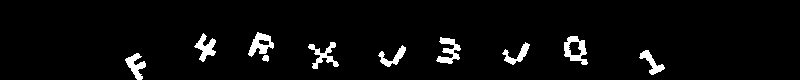

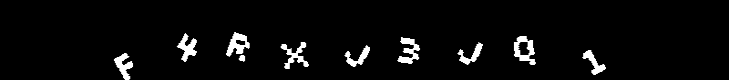

tensor([[[[0.3631]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2394]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1845]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1980]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3711]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4276]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


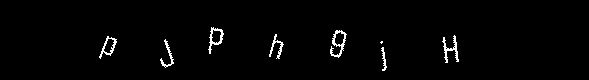

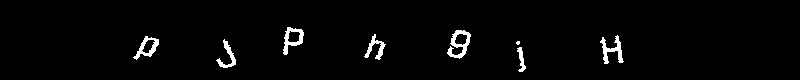

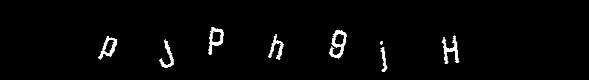

tensor([[[[0.3344]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [44]:
def display_image_ori_width(img_tensor, ori_width):
    img_array = ((img_tensor.numpy() * 0.5 + 0.5) * 255).astype(np.uint8)
    img_array[img_array < 128] = 0
    img_array[img_array >= 128] = 255
    display(Image.fromarray(img_array[0], 'L').resize((ori_width, 80), resample=3))

for _ in range(100):
  random_captcha = generate_random_captcha()
  width = random_captcha.size[0]
  generator_output = netG(torch.stack([transform(random_captcha)]).to(device))
  verdict = netD(generator_output)
  print(verdict)
  if verdict > 0.4:
    generator_output = generator_output[0].cpu().detach()
    display(random_captcha)
    display_image(generator_output)
    display_image_ori_width(generator_output, width)


## Export models

In [45]:
NET_G_PATH = "./GAN/netG.pt"
NET_D_PATH = "./GAN/netD.pt"

In [47]:
torch.save(netG.state_dict(), NET_G_PATH)
torch.save(netD.state_dict(), NET_D_PATH)

## Import models

tensor([[[[0.2512]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4108]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


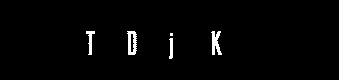

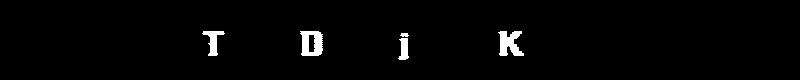

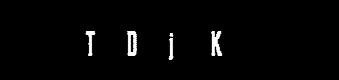

tensor([[[[0.1907]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4422]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


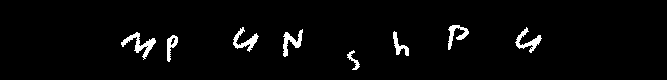

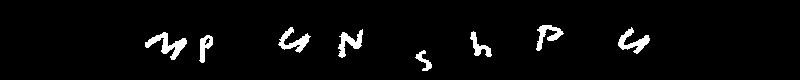

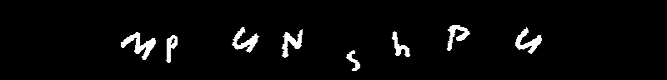

tensor([[[[0.3548]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2994]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3965]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4198]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


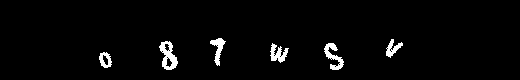

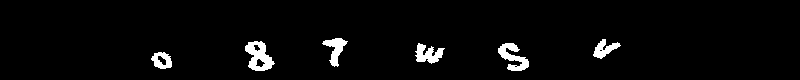

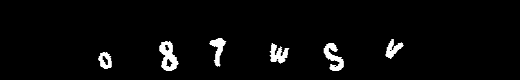

tensor([[[[0.7874]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


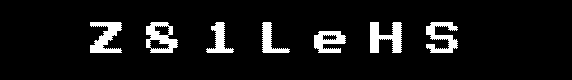

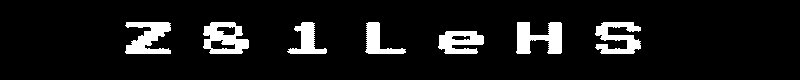

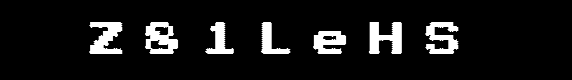

tensor([[[[0.6602]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


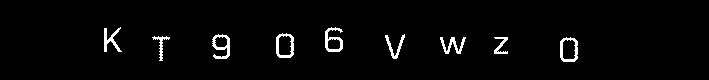

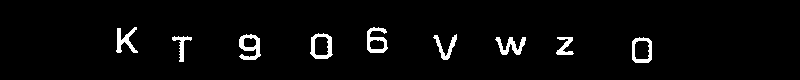

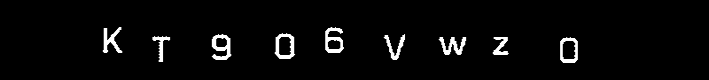

tensor([[[[0.2456]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2228]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3068]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4160]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


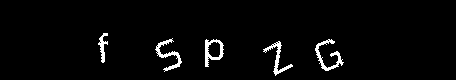

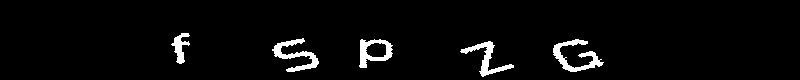

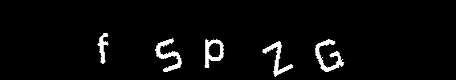

tensor([[[[0.4515]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


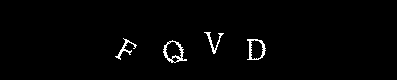

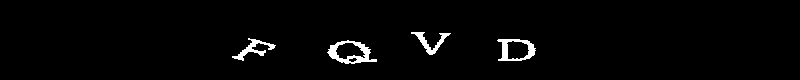

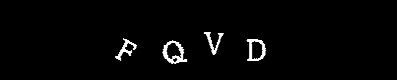

tensor([[[[0.1822]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2966]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2011]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3992]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.0905]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5387]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


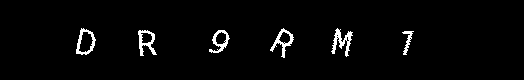

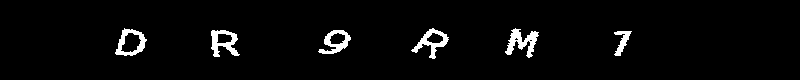

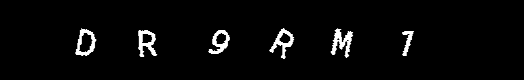

tensor([[[[0.1908]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.7151]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


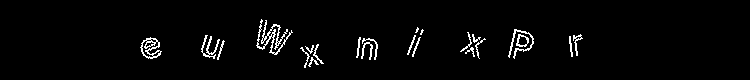

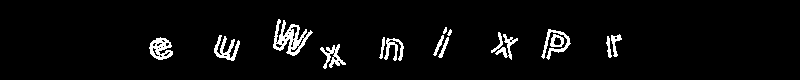

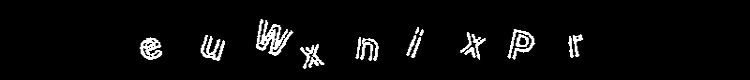

tensor([[[[0.3058]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5525]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


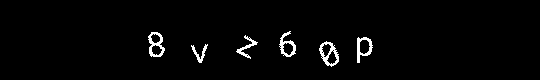

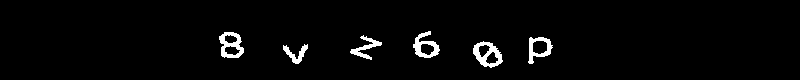

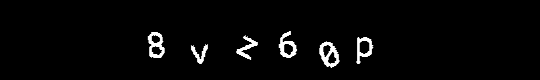

tensor([[[[0.2129]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4768]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


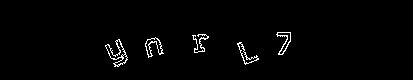

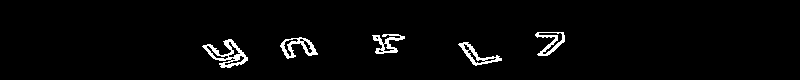

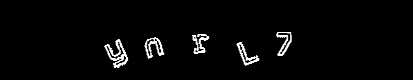

tensor([[[[0.4196]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


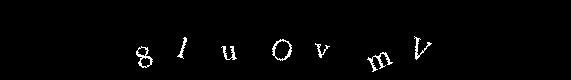

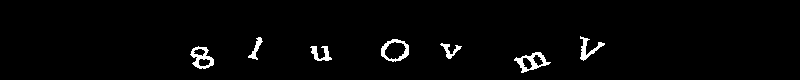

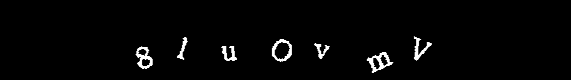

tensor([[[[0.5050]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


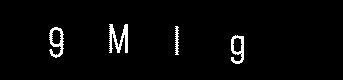

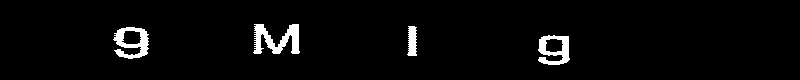

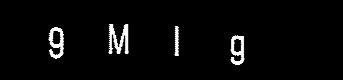

tensor([[[[0.4011]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


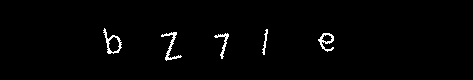

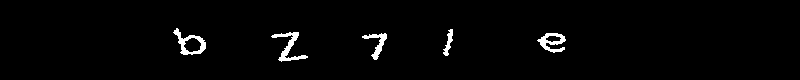

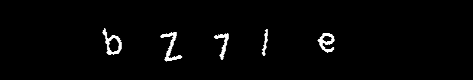

tensor([[[[0.2801]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.7571]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


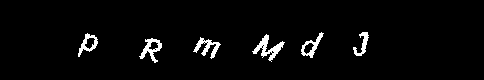

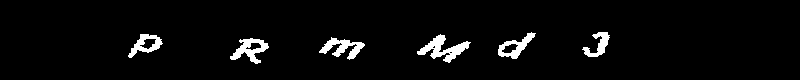

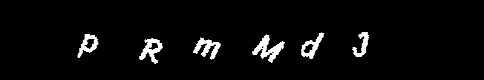

tensor([[[[0.5098]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


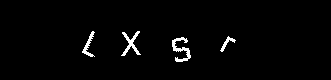

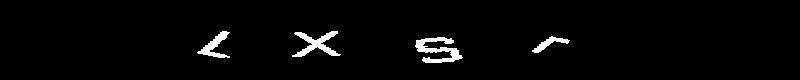

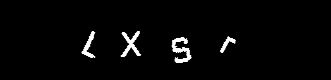

tensor([[[[0.2004]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3888]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2628]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2346]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1789]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3157]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4335]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


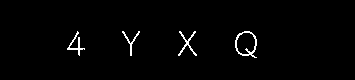

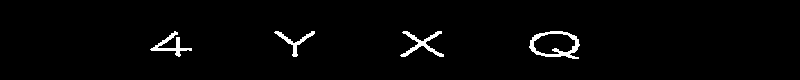

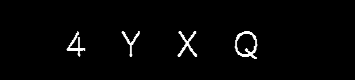

tensor([[[[0.3455]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1690]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4517]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


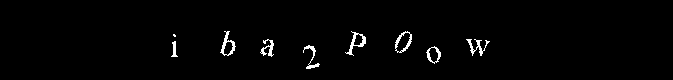

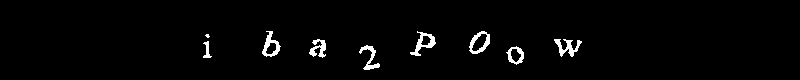

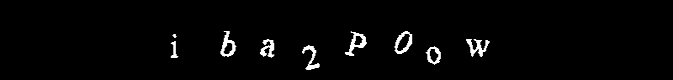

tensor([[[[0.3060]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3652]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.7315]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


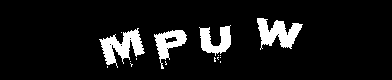

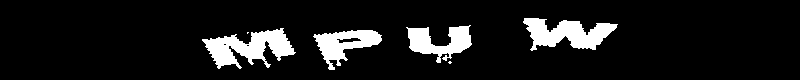

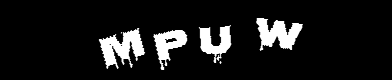

tensor([[[[0.4391]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


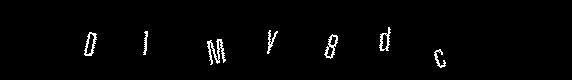

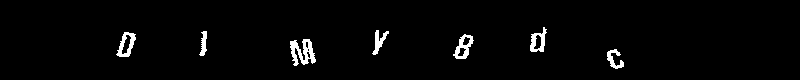

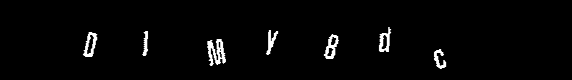

tensor([[[[0.6904]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


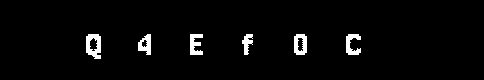

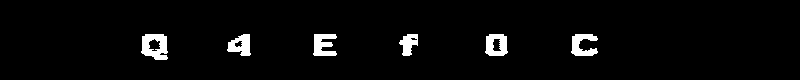

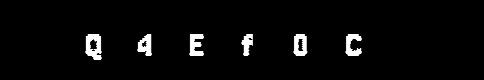

tensor([[[[0.4275]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


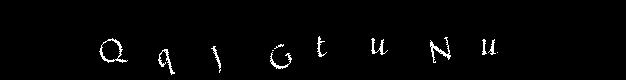

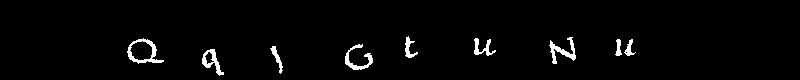

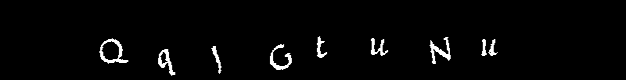

tensor([[[[0.1847]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4826]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


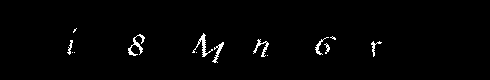

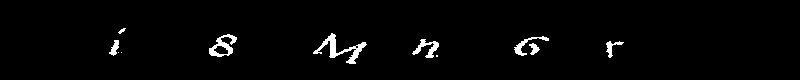

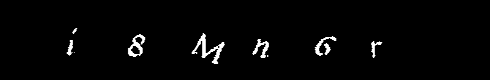

tensor([[[[0.4125]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


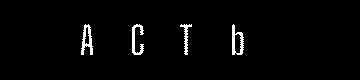

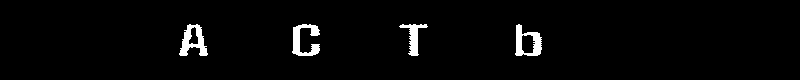

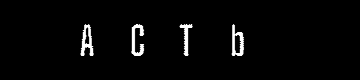

tensor([[[[0.5506]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


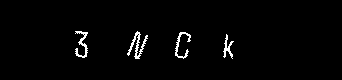

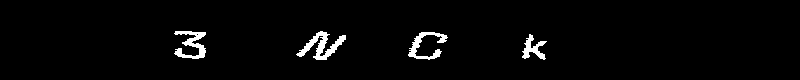

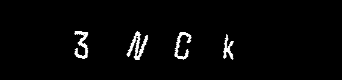

tensor([[[[0.2992]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5888]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


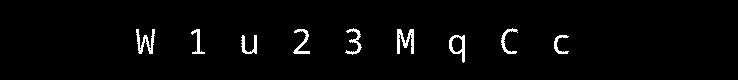

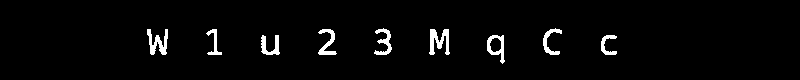

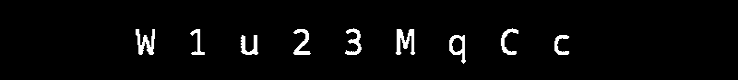

tensor([[[[0.6433]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


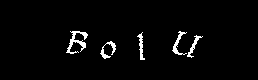

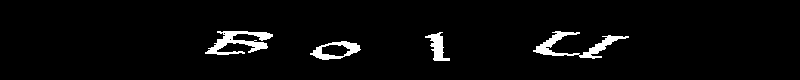

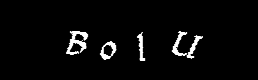

tensor([[[[0.4208]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


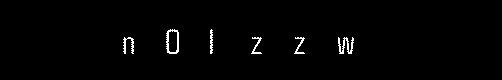

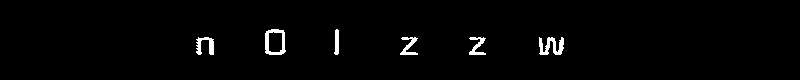

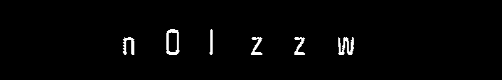

tensor([[[[0.2362]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3196]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3914]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1753]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2211]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3806]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2855]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2171]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3567]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2339]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3596]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2466]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.8630]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


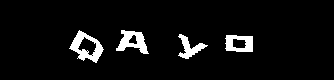

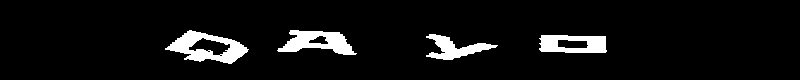

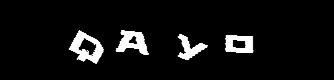

tensor([[[[0.2769]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2190]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3558]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.7790]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


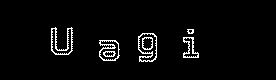

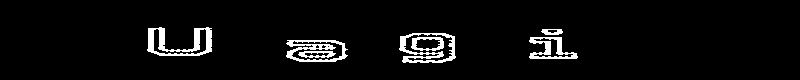

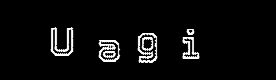

tensor([[[[0.2567]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2057]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1444]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3533]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2206]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1702]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3186]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3581]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2119]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2302]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1578]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3321]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5143]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


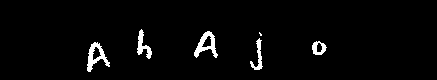

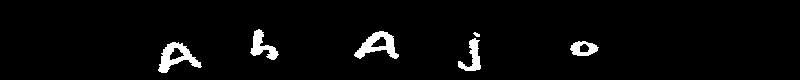

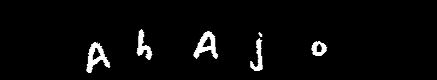

tensor([[[[0.3003]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4267]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


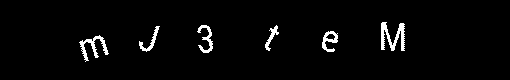

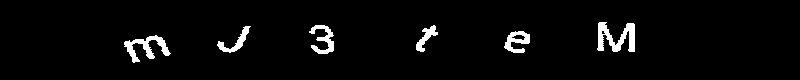

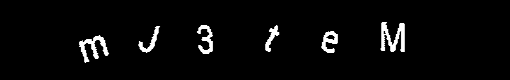

tensor([[[[0.5910]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


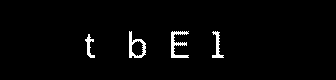

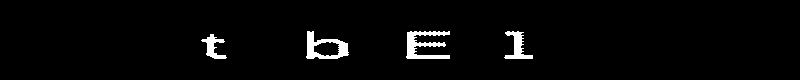

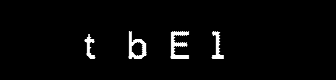

tensor([[[[0.4127]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


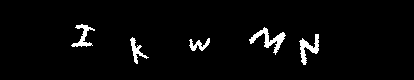

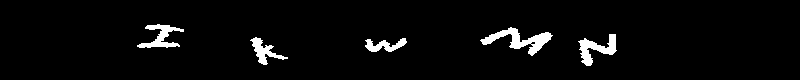

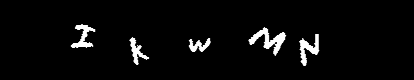

tensor([[[[0.4458]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


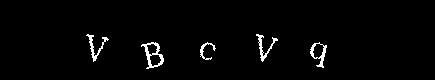

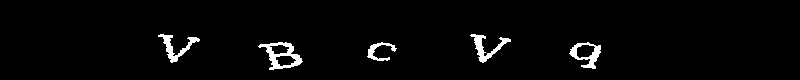

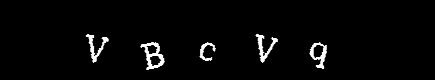

tensor([[[[0.3798]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1551]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2105]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4916]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


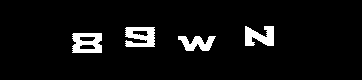

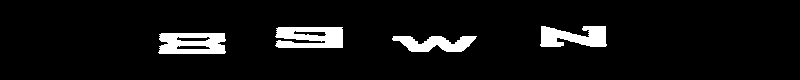

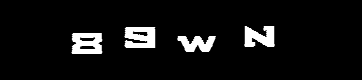

tensor([[[[0.2141]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3207]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3755]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1277]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [49]:
imported_netG = Generator().to(device)
imported_netD = Discriminator().to(device)

imported_netG.load_state_dict(torch.load(NET_G_PATH, weights_only=True))
imported_netD.load_state_dict(torch.load(NET_D_PATH, weights_only=True))

for _ in range(100):
  random_captcha = generate_random_captcha()
  width = random_captcha.size[0]
  generator_output = imported_netG(torch.stack([transform(random_captcha)]).to(device))
  verdict = imported_netD(generator_output)
  print(verdict)
  if verdict > 0.4:
    generator_output = generator_output[0].cpu().detach()
    display(random_captcha)
    display_image(generator_output)
    display_image_ori_width(generator_output, width)

## Generate

In [81]:
def save_image_ori_width(img_tensor, ori_width, path):
    img_array = ((img_tensor.numpy() * 0.5 + 0.5) * 255).astype(np.uint8)
    img_array[img_array < 128] = 0
    img_array[img_array >= 128] = 255
    img = Image.fromarray(img_array[0], 'L').resize((ori_width, 80), resample=3)
    img.save(path, 'PNG')

In [82]:
# Define transformation pipeline
transform = transforms.Compose([
    transforms.Resize((80, 800)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1,1]
])

In [ ]:
NUM_TO_GENERATE = 5000
NET_G_PATH = "./GAN/netG.pt"
NET_D_PATH = "./GAN/netD.pt"
IMAGE_SAVE_DIR = "./data/generated_images/"

if not os.path.exists(IMAGE_SAVE_DIR):
    os.mkdir(IMAGE_SAVE_DIR)

imported_netG = Generator().to(device)
imported_netD = Discriminator().to(device)

imported_netG.load_state_dict(torch.load(NET_G_PATH, weights_only=True))
imported_netD.load_state_dict(torch.load(NET_D_PATH, weights_only=True))

count = 0
with tqdm(total=NUM_TO_GENERATE) as pbar:
    while count < NUM_TO_GENERATE:
        random_captcha, label = generate_random_captcha(return_label = True)
        width = random_captcha.size[0]
        generator_output = imported_netG(torch.stack([transform(random_captcha)]).to(device))
        verdict = imported_netD(generator_output)
        if verdict > 0.4:
            img_tensor = generator_output[0].cpu().detach()
            path = f'{IMAGE_SAVE_DIR}{label}.png'
            save_image_ori_width(img_tensor, width, path)
            count += 1
            pbar.update(1)


## Generate from original images

In [83]:
def save_image_ori_width_height(img_tensor, ori_width, ori_height, path):
    img_array = ((img_tensor.numpy() * 0.5 + 0.5) * 255).astype(np.uint8)
    img_array[img_array < 128] = 0
    img_array[img_array >= 128] = 255
    img = Image.fromarray(img_array[0], 'L').resize((ori_width, ori_height), resample=3)
    img.save(path, 'PNG')

In [87]:
NET_G_PATH = "./GAN/netG.pt"
NET_D_PATH = "./GAN/netD.pt"
ORI_IMAGES_DIR = "./data/preprocessed_images/"
IMAGE_SAVE_DIR = "./data/preprocessed_images_GAN_modified/"

if not os.path.exists(IMAGE_SAVE_DIR):
    os.mkdir(IMAGE_SAVE_DIR)

imported_netG = Generator().to(device)
imported_netD = Discriminator().to(device)

imported_netG.load_state_dict(torch.load(NET_G_PATH, weights_only=True))
imported_netD.load_state_dict(torch.load(NET_D_PATH, weights_only=True))

count = 0
ori_dataset = CaptchaDataset(image_folder=ORI_IMAGES_DIR, transform=None)

for i in tqdm(range(len(ori_dataset))):
    ori_image = ori_dataset[i]
    width, height = ori_image.size
    ori_image_tensor = transform(ori_image)
    generator_output = imported_netG(ori_image_tensor.to(device))
    verdict = imported_netD(generator_output)
    if verdict > 0.4:
        img_tensor = generator_output.cpu().detach()
        filename = ori_dataset.image_files[i]
        path = f'{IMAGE_SAVE_DIR}{filename}'
        save_image_ori_width_height(img_tensor, width, height, path)


100%|██████████████████████████████████████| 7715/7715 [00:40<00:00, 191.61it/s]
